# End-to-End BO on a Semi-Realistic Fire Scenario

This notebook reproduces the Victoria-style semi-realistic environment from `scenarios_final_all_BO.ipynb` and runs Bayesian optimization for retardant drop placement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fire_model.ca import FireEnv, CAFireModel
from fire_model.bo import RetardantDropBayesOpt

np.set_printoptions(precision=4, suppress=True)

## Helper functions (plotting + ignition placement)

Note: slope only affects spread if you have applied the slope patch mentioned in the original notebook.

In [2]:
# Helper: distance-to-polyline

def distance_to_curve(xgrid, ygrid, pts):
    dmin = np.full(xgrid.shape, np.inf, dtype=float)
    for px, py in pts:
        d = np.sqrt((xgrid - px) ** 2 + (ygrid - py) ** 2)
        dmin = np.minimum(dmin, d)
    return dmin


def plot_env(env, elev_m, slope, town_centers, road_mask, river_mask, riparian_mask, phase1_steps):
    fuel = np.asarray(env.fuel, float)
    value = np.asarray(env.value, float)
    wind = np.asarray(env.wind, float)

    slope = np.asarray(slope)
    slope_deg = np.degrees(np.arctan(np.sqrt(slope[..., 0] ** 2 + slope[..., 1] ** 2)))

    mean_vec = wind.reshape(wind.shape[0], -1, 2).mean(axis=1)
    u = mean_vec[:, 0]
    v = mean_vec[:, 1]
    spd = np.sqrt(u ** 2 + v ** 2)
    wdir = (np.degrees(np.arctan2(v, u)) + 360.0) % 360.0

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))

    def overlay(ax):
        ax.contour(road_mask.T.astype(float), levels=[0.5], linewidths=1.0, colors="k")
        ax.contour(river_mask.T.astype(float), levels=[0.5], linewidths=1.0, colors="b")
        ax.contour(riparian_mask.T.astype(float), levels=[0.5], linewidths=0.8, colors="c", linestyles="--")
        for (ti, tj) in town_centers:
            ax.plot(ti, tj, "wo", ms=6, mec="k")
        ax.set_xlabel("x cell")
        ax.set_ylabel("y cell")

    ax = axes[0, 0]
    im = ax.imshow(elev_m.T, origin="lower", cmap="terrain")
    ax.set_title("Elevation (m)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[0, 1]
    im = ax.imshow(slope_deg.T, origin="lower", cmap="magma")
    ax.set_title("Slope (deg)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[0, 2]
    im = ax.imshow(fuel.T, origin="lower", cmap="YlOrBr")
    ax.set_title("Fuel")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[1, 0]
    im = ax.imshow(value.T, origin="lower", cmap="viridis")
    ax.set_title("Value at risk")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[1, 1]
    mask = np.zeros_like(fuel)
    mask[road_mask] = 1.0
    mask[riparian_mask] = 2.0
    mask[river_mask] = 3.0
    im = ax.imshow(mask.T, origin="lower", cmap="tab20")
    ax.set_title("Roads / riparian / river")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = axes[1, 2]
    ax.plot(spd, label="wind speed (m/s)")
    ax.axvline(phase1_steps, color="k", linestyle="--", linewidth=1.0)
    ax.set_xlabel("time step")
    ax.set_ylabel("speed (m/s)")
    ax2 = ax.twinx()
    ax2.plot(wdir, color="tab:orange", label="wind dir (deg)")
    ax2.set_ylabel("direction (deg)")
    ax.set_title("Wind summary")

    fig.tight_layout()


def choose_ignition_upwind(env, town_centers, wind_uv, offset_cells=55):
    'Pick an ignition center roughly upwind of the main town center.'
    nx, ny = env.grid_size
    u, v = wind_uv
    ti, tj = town_centers[0]
    norm = np.sqrt(u * u + v * v) + 1e-9
    di = int(np.round(-u / norm * offset_cells))
    dj = int(np.round(-v / norm * offset_cells))
    ci = int(np.clip(ti + di, 5, nx - 6))
    cj = int(np.clip(tj + dj, 5, ny - 6))
    return (ci, cj)

## Build the Victoria-style scenario

This block mirrors the semi-realistic environment in `scenarios_final_all_BO.ipynb`.

In [15]:
# Grid
nx = ny = 400
domain_km = 10.0
dx_m = (domain_km / nx) * 1000.0

xs = np.linspace(-3.2, 3.2, nx)[:, None]
ys = np.linspace(-3.2, 3.2, ny)[None, :]
X = xs.repeat(ny, axis=1)
Y = ys.repeat(nx, axis=0)

rng = np.random.default_rng(11)

# Terrain
raw = rng.normal(size=(nx, ny))
smooth = raw.copy()
for _ in range(6):
    smooth = (
        0.40 * smooth
        + 0.10 * np.roll(smooth, 1, 0) + 0.10 * np.roll(smooth, -1, 0)
        + 0.10 * np.roll(smooth, 1, 1) + 0.10 * np.roll(smooth, -1, 1)
        + 0.05 * np.roll(np.roll(smooth, 1, 0), 1, 1)
        + 0.05 * np.roll(np.roll(smooth, -1, 0), -1, 1)
        + 0.05 * np.roll(np.roll(smooth, 1, 0), -1, 1)
        + 0.05 * np.roll(np.roll(smooth, -1, 0), 1, 1)
    )
smooth = (smooth - smooth.mean()) / (smooth.std() + 1e-9)

valley = -95.0 * np.exp(-((Y + 0.05) ** 2) / 0.35)
upland = 65.0 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 1.10))
west_rise = 40.0 * (1.0 / (1.0 + np.exp((X - 0.3) / 0.55)))

elev_m = 190.0 + valley + upland + west_rise + 18.0 * smooth
elev_m = np.clip(elev_m, 80.0, 360.0)

# River
rt = np.linspace(-3.2, 3.2, 260)
river_x0 = -0.45
river_x = river_x0 + 0.22 * np.sin(0.75 * rt) + 0.08 * np.sin(2.3 * rt)
river_y = rt
river_pts = np.stack([river_x, river_y], axis=1)
d_river = distance_to_curve(X, Y, river_pts)

river_mask = d_river < 0.035
riparian_mask = d_river < 0.095

elev_m = elev_m - 14.0 * np.exp(-(d_river ** 2) / (2 * 0.030 ** 2))
elev_m = np.clip(elev_m, 70.0, 360.0)

# Slope

dzdx = np.gradient(elev_m, dx_m, axis=0)
dzdy = np.gradient(elev_m, dx_m, axis=1)
slope = np.stack([dzdx, dzdy], axis=-1)
slope_deg = np.degrees(np.arctan(np.sqrt(dzdx ** 2 + dzdy ** 2)))

# Towns
flat = slope_deg < 6.0
not_water = ~river_mask

cand0 = flat & not_water & (np.abs(Y) < 0.85) & (d_river > 0.07) & (d_river < 0.20) & (X < 0.5)
cand1 = flat & not_water & (np.abs(Y) < 0.90) & (d_river > 0.35) & (X > 0.6)

def pick_town(mask, prefer_x, prefer_y=0.0):
    score = mask.astype(float)
    score *= np.exp(-(slope_deg ** 2) / (2 * 4.0 ** 2))
    score *= np.exp(-((Y - prefer_y) ** 2) / (2 * 0.60 ** 2))
    score *= np.exp(-((X - prefer_x) ** 2) / (2 * 0.80 ** 2))
    i, j = np.unravel_index(np.argmax(score), score.shape)
    return (i, j)

town0 = pick_town(cand0, prefer_x=-0.2, prefer_y=0.1)
town1 = pick_town(cand1, prefer_x=1.6, prefer_y=-0.1)

# Roads

t = np.linspace(-3.2, 3.2, 260)
hw_pts = np.stack([t, -0.10 + 0.22 * np.sin(0.55 * t)], axis=1)
d_hw = distance_to_curve(X, Y, hw_pts)

junction_x = river_x0 - 0.55
k_j = int(np.argmin(np.abs(hw_pts[:, 0] - junction_x)))
junction = hw_pts[k_j]

s = np.linspace(0.0, 1.0, 340)
nw_start = np.array([-3.2, 3.2])
feeder = (1 - s)[:, None] * nw_start + s[:, None] * junction
feeder[:, 1] += 0.24 * np.sin(np.pi * s)
d_feeder = distance_to_curve(X, Y, feeder)


def nearest_point(poly_pts, p):
    d = np.sqrt((poly_pts[:, 0] - p[0]) ** 2 + (poly_pts[:, 1] - p[1]) ** 2)
    return poly_pts[int(np.argmin(d))]


def connector(town_xy, hw_pts, bend_sign, n=160):
    hx, hy = nearest_point(hw_pts, town_xy)
    s = np.linspace(0.0, 1.0, n)
    x = (1 - s) * town_xy[0] + s * hx
    y = (1 - s) * town_xy[1] + s * hy + 0.10 * np.sin(np.pi * s) * bend_sign
    return np.stack([x, y], axis=1)


town0_xy = (xs[town0[0], 0], ys[0, town0[1]])
town1_xy = (xs[town1[0], 0], ys[0, town1[1]])

conn0 = connector(town0_xy, hw_pts, bend_sign=1.0)
conn1 = connector(town1_xy, hw_pts, bend_sign=-1.0)
d_conn0 = distance_to_curve(X, Y, conn0)
d_conn1 = distance_to_curve(X, Y, conn1)

road_mask = (d_hw < 0.045) | (d_feeder < 0.040) | (d_conn0 < 0.030) | (d_conn1 < 0.030)

# Small town near the feeder
near_feeder = (d_feeder > 0.02) & (d_feeder < 0.10)
away_from_junction = np.sqrt((X - junction[0]) ** 2 + (Y - junction[1]) ** 2) > 0.9
cand_small = flat & not_water & near_feeder & away_from_junction & (X < -1.4) & (Y > 0.6)

small_town = pick_town(cand_small, prefer_x=-2.2, prefer_y=1.6)

# Flatten pads for towns
for (ti, tj) in [town0, town1, small_town]:
    cx = xs[ti, 0]
    cy = ys[0, tj]
    r2 = (X - cx) ** 2 + (Y - cy) ** 2
    pad = np.exp(-r2 / (2 * 0.18 ** 2))
    elev_m = (1.0 - 0.60 * pad) * elev_m + (0.60 * pad) * elev_m[ti, tj]

# Recompute slope after flattening

dzdx = np.gradient(elev_m, dx_m, axis=0)
dzdy = np.gradient(elev_m, dx_m, axis=1)
slope = np.stack([dzdx, dzdy], axis=-1)
slope_deg = np.degrees(np.arctan(np.sqrt(dzdx ** 2 + dzdy ** 2)))

town_centers = [town0, town1, small_town]

# Fuels

fuel = 0.85 * np.ones((nx, ny), dtype=float)
upland_fuel = 1.05 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 1.10))
fuel += upland_fuel

patch = rng.normal(size=(nx, ny))
for _ in range(4):
    patch = (
        0.60 * patch
        + 0.10 * np.roll(patch, 1, 0) + 0.10 * np.roll(patch, -1, 0)
        + 0.10 * np.roll(patch, 1, 1) + 0.10 * np.roll(patch, -1, 1)
    )
patch = (patch - patch.mean()) / (patch.std() + 1e-9)
fuel *= (1.0 + 0.08 * patch)

fuel *= np.where(road_mask, 0.35, 1.0)
fuel *= np.where(river_mask, 0.05, 1.0)
fuel *= np.where(riparian_mask & (~river_mask), 0.75, 1.0)
fuel = np.clip(fuel, 0.05, 3.10)

# Values-at-risk

value = np.ones((nx, ny), dtype=float)

def add_town_value(center, core_amp, core_sigma, wui_amp, wui_sigma):
    ti, tj = center
    cx = xs[ti, 0]
    cy = ys[0, tj]
    r2 = (X - cx) ** 2 + (Y - cy) ** 2
    return core_amp * np.exp(-r2 / core_sigma) + wui_amp * np.exp(-r2 / wui_sigma)

value += add_town_value(town0, core_amp=20.0, core_sigma=0.085, wui_amp=3.2, wui_sigma=0.26)
value += add_town_value(town1, core_amp=20.0, core_sigma=0.08, wui_amp=3.0, wui_sigma=0.25)
value += add_town_value(small_town, core_amp=20, core_sigma=0.07, wui_amp=2.0, wui_sigma=0.20)

value += 0.8 * road_mask.astype(float)
value += 1.2 * (riparian_mask & (~river_mask)).astype(float)

# Wind (NW prefrontal then SW change)

dt_s = 10.0
T_hours = 6.0
num_steps = int(T_hours * 3600 / dt_s)

wind = np.zeros((num_steps, nx, ny, 2), dtype=float)

phase1_steps = int(4.0 * 3600 / dt_s)
w1 = 15.0
wind[:phase1_steps, ..., 0] = +w1 / np.sqrt(2)
wind[:phase1_steps, ..., 1] = -w1 / np.sqrt(2)

w2 = 12.0
wind[phase1_steps:, ..., 0] = +w2 / np.sqrt(2)
wind[phase1_steps:, ..., 1] = +w2 / np.sqrt(2)

gust = rng.normal(0.0, 1.0, size=(num_steps, 1, 1, 2))
wind *= (1.0 + 0.10 * gust)
wind = np.clip(wind, -25.0, 25.0)

# FireEnv

realistic_env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    slope=slope,
    dt_s=dt_s,
    burn_time_s0=600.0,
    retardant_half_life_s=172800.0,
    retardant_k=20,
    drop_w_km=0.05,
    drop_h_km=0.50,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.06,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
    ros_future_jitter_frac=0.15,
    wind_coeff_future_jitter_frac=0.20,
)

realistic_bundle = (
    realistic_env,
    elev_m,
    slope,
    town_centers,
    road_mask,
    river_mask,
    riparian_mask,
    phase1_steps,
)

## Visualize the scenario

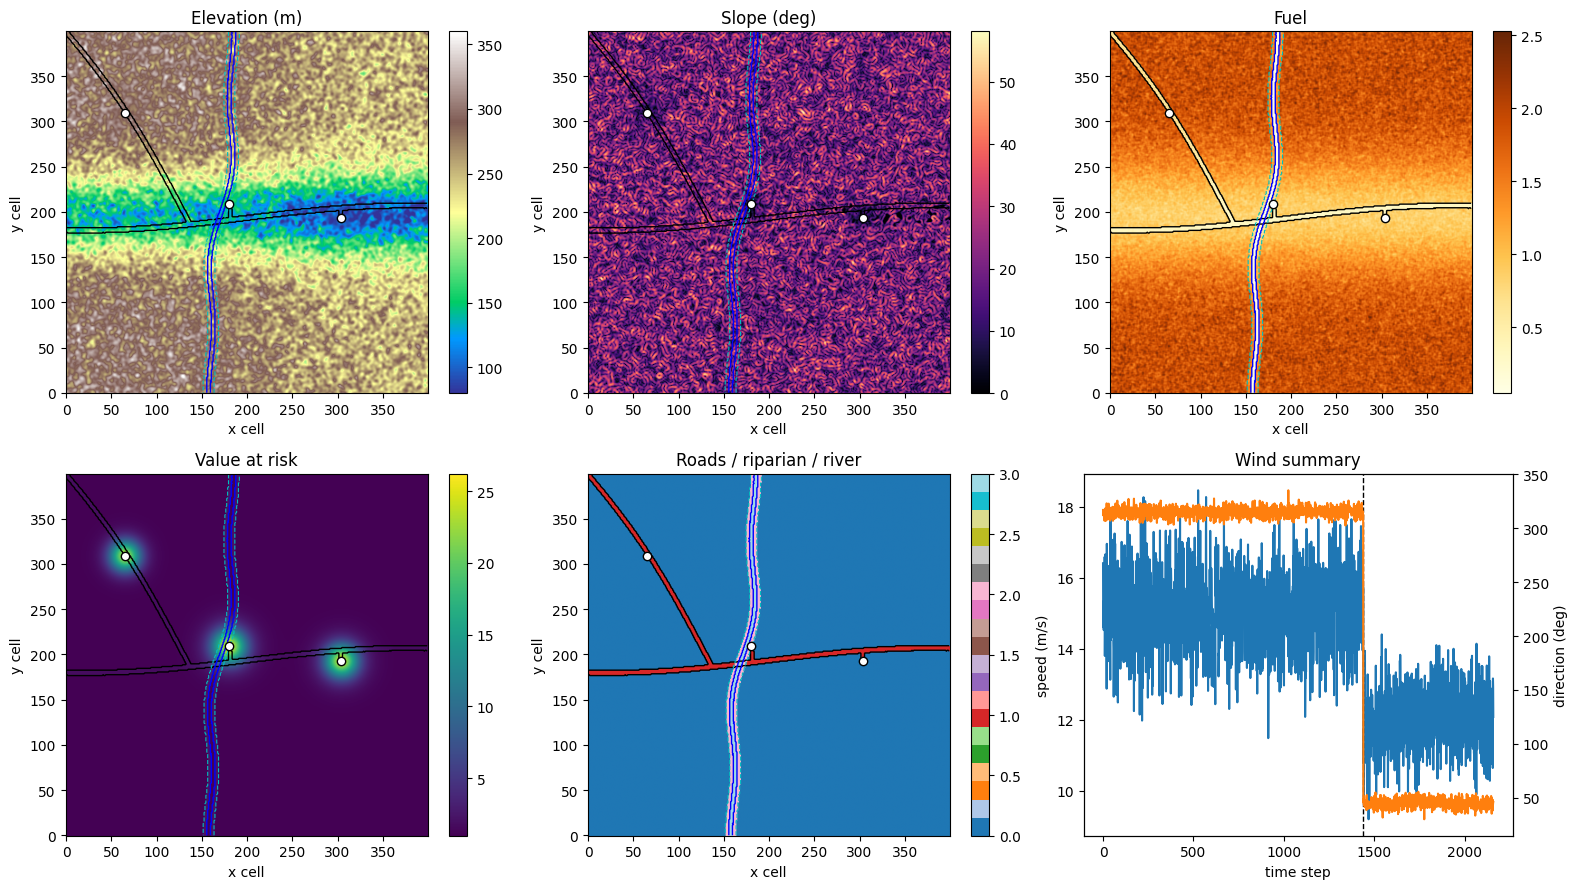

In [16]:
plot_env(*realistic_bundle)

## Set up the fire model and optimizer

In [17]:
# Model and ignition
n_drones = 20
n_sims = 50
evolution_time_s = 300
search_grid_time_s = 300
ignition_radius_km = 0.2

fire_model = CAFireModel(realistic_env, seed=0)

w0 = np.asarray(realistic_env.wind)[0]
wind_uv = (float(w0[..., 0].mean()), float(w0[..., 1].mean()))
ignition_center = choose_ignition_upwind(realistic_env, town_centers, wind_uv)

init_firestate = fire_model.init_state_batch(
    n_sims=n_sims,
    center=ignition_center,
    radius_km=ignition_radius_km,
)

drop_opt = RetardantDropBayesOpt(
    fire_model=fire_model,
    init_firestate=init_firestate,
    n_drones=n_drones,
    evolution_time_s=evolution_time_s,
    n_sims=n_sims,
    fire_boundary_probability=0.25,
    search_grid_evolution_time_s=search_grid_time_s,
    rng=np.random.default_rng(0),
)

print("ignition_center:", ignition_center)
print("wind_uv:", wind_uv)

ignition_center: (140, 247)
wind_uv: (11.969512433322961, -11.218169641446421)


## Search grid and Bayesian optimization

The settings below follow your requested BO configuration. This is a heavier run; reduce `n_iters` or `n_candidates` for quick iterations.

search cells: 3816


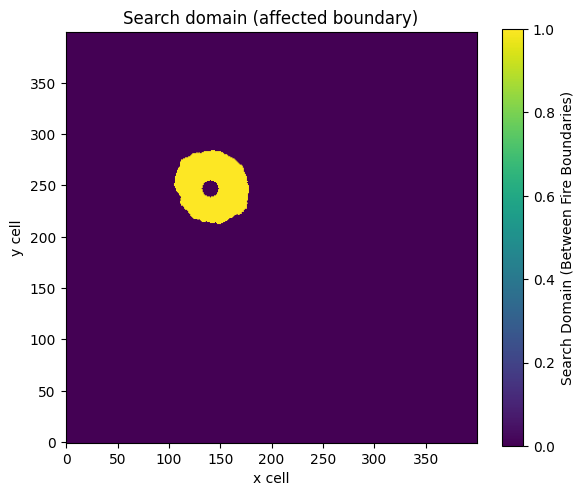

In [19]:
search_mask, coords = drop_opt.setup_search_grid(K=500, boundary_field="affected") #K 
print("search cells:", coords.shape[0])

# Optional: visualize the search domain
fire_model.plot_search_domain(search_mask, title="Search domain (affected boundary)")

[Heuristic] eval 001/10 | y=191.678 | best=191.678
           (x,y,phi) per drone:
           [[ 18.       4.       2.8222]
 [ 45.     114.       4.3698]
 [ 84.      98.       1.4001]
 [ 87.     107.       2.9571]
 [ 90.     143.       3.315 ]
 [100.      73.       0.5558]
 [107.      26.       1.9388]
 [125.      53.       0.6295]
 [133.     135.       5.3592]
 [134.      82.       6.2356]]
[Heuristic] eval 010/10 | y=191.703 | best=191.263
           (x,y,phi) per drone:
           [[  1.      83.       0.2057]
 [  8.      67.       0.3135]
 [ 28.      39.       4.0218]
 [ 37.      76.       2.8308]
 [ 48.      47.       2.2912]
 [ 53.     119.       2.7334]
 [ 77.      49.       5.0056]
 [ 78.     108.       0.9392]
 [125.     132.       6.1709]
 [141.      93.       4.1935]]
[Heuristic] done: best_y=191.263
[Heuristic] best params:
[[ 11.      72.       1.6196]
 [ 25.     102.       2.5209]
 [ 30.      25.       2.925 ]
 [ 88.     110.       0.3021]
 [ 94.      81.       3.4887]
 [

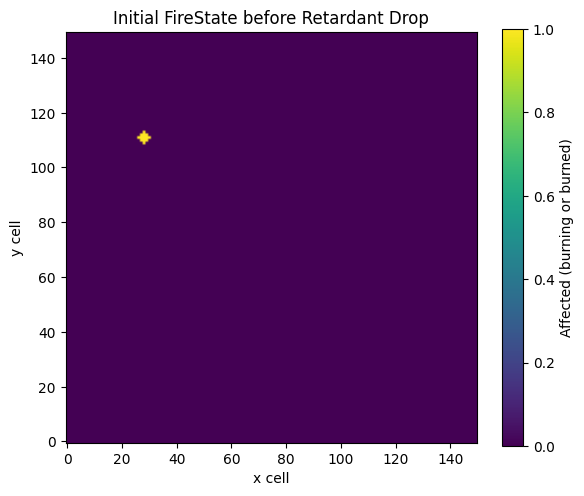

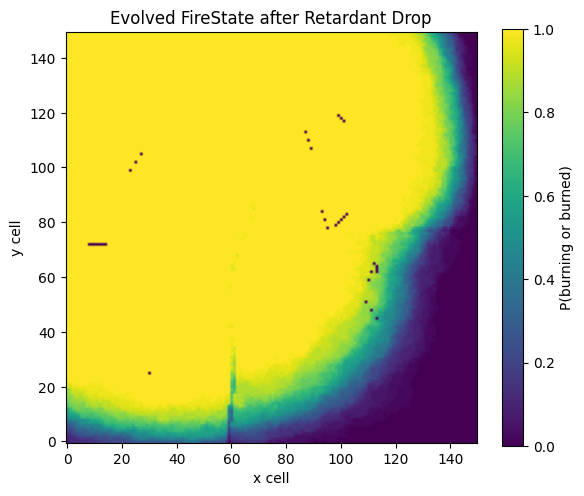

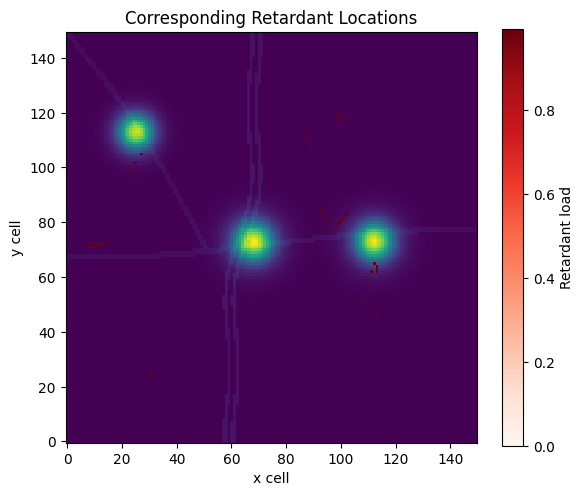

In [40]:
best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests =drop_opt.run_heuristic_search(
    n_evals=10,
    heuristic_random_frac=0.0,
    print_every=10,
)

drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

#### sweeps (finer grid)

=== H1+H2+H3 (default) ===
[Heuristic] Search grid set up with 3816 valid cells in grid.


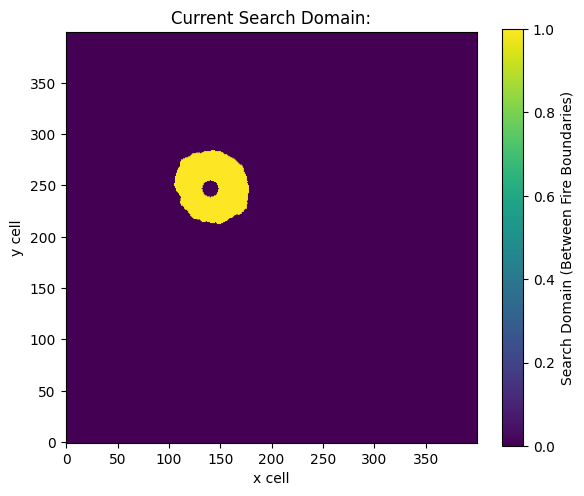

[Heuristic] eval 001/10 | y=2.45717 | best=2.45717
           (x,y,phi) per drone:
           [[112.     231.       2.5194]
 [124.     218.       1.5794]
 [142.     235.       0.3684]
 [144.     284.       4.5969]
 [145.     235.       0.7621]
 [145.     236.       0.4159]
 [147.     236.       0.4153]
 [148.     236.       0.8723]
 [148.     237.       0.9795]
 [149.     239.       0.8578]
 [151.     238.       0.9282]
 [151.     241.       0.6391]
 [151.     243.       0.7095]
 [152.     241.       0.6452]
 [152.     241.       0.9835]
 [152.     244.       0.8635]
 [156.     280.       4.4819]
 [171.     269.       5.5307]
 [171.     269.       5.8158]
 [176.     254.       0.3495]]
[Heuristic] eval 010/10 | y=2.21879 | best=2.07293
           (x,y,phi) per drone:
           [[111.     233.       2.6216]
 [124.     218.       2.2118]
 [124.     218.       2.2958]
 [132.     215.       1.7619]
 [144.     235.       0.608 ]
 [146.     235.       1.1624]
 [146.     236.       0.6015]
 

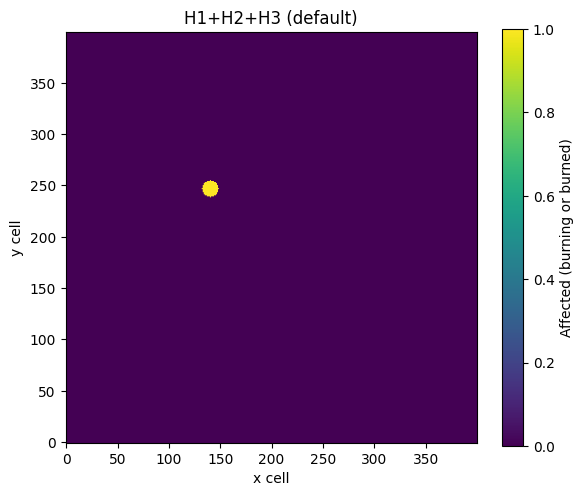

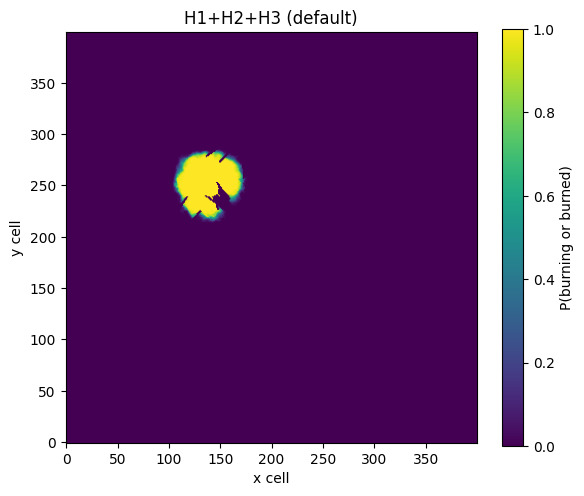

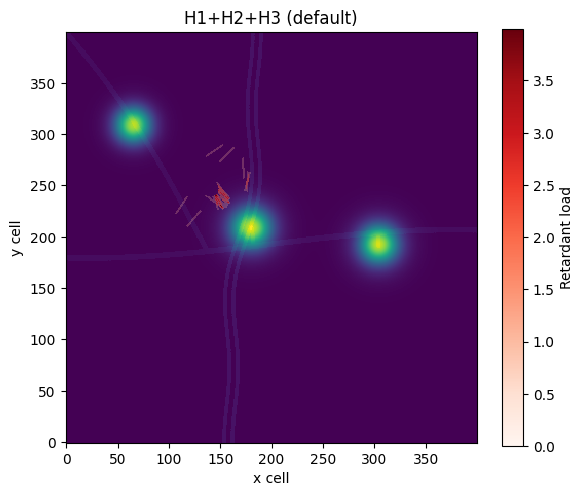

=== H1 asset-heavy (tight assets) ===
[Heuristic] eval 001/10 | y=3.01614 | best=3.01614
           (x,y,phi) per drone:
           [[151.     234.       0.756 ]
 [152.     232.       0.5591]
 [152.     233.       0.5925]
 [153.     232.       0.6699]
 [153.     233.       0.7829]
 [153.     237.       0.6815]
 [154.     231.       0.4781]
 [154.     231.       0.6718]
 [154.     231.       0.7316]
 [154.     232.       0.751 ]
 [154.     234.       0.87  ]
 [155.     233.       0.7221]
 [155.     233.       0.7787]
 [155.     235.       0.681 ]
 [155.     238.       0.8809]
 [155.     239.       0.9213]
 [156.     237.       0.795 ]
 [157.     235.       0.496 ]
 [157.     235.       0.8717]
 [158.     234.       0.8356]]
[Heuristic] eval 010/10 | y=3.01595 | best=2.9157
           (x,y,phi) per drone:
           [[150.     233.       0.645 ]
 [150.     234.       0.5349]
 [151.     234.       0.5723]
 [152.     233.       0.7464]
 [152.     233.       0.7701]
 [153.     232.       0.

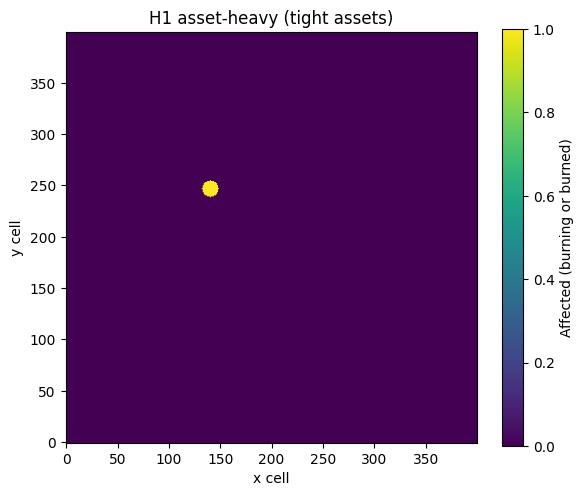

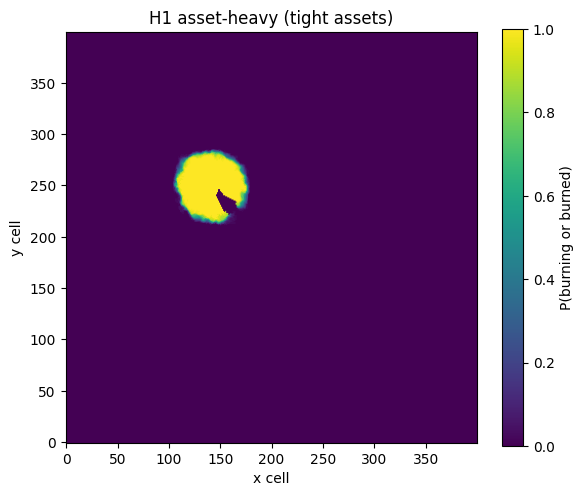

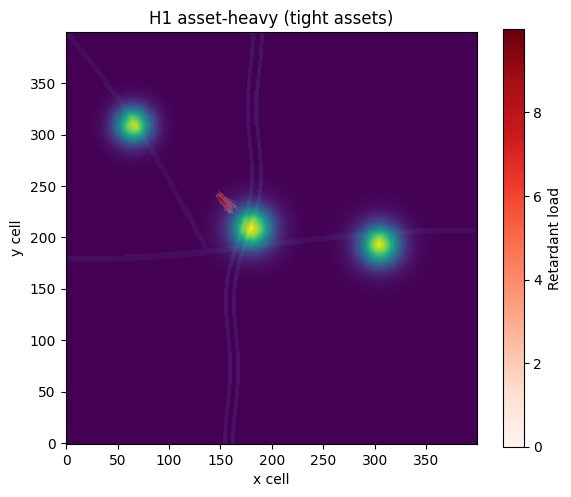

=== H1+H2 (assets + downwind barrier) ===
[Heuristic] eval 001/10 | y=2.33956 | best=2.33956
           (x,y,phi) per drone:
           [[145.     234.       0.6602]
 [145.     236.       0.5319]
 [146.     233.       0.6321]
 [146.     233.       0.794 ]
 [146.     236.       0.684 ]
 [147.     237.       0.6261]
 [147.     237.       0.8034]
 [148.     234.       0.6082]
 [149.     237.       0.5566]
 [149.     239.       0.7012]
 [150.     235.       0.9476]
 [151.     239.       0.6338]
 [151.     242.       0.6071]
 [152.     236.       0.7837]
 [152.     240.       0.7159]
 [153.     238.       0.9611]
 [153.     242.       1.1622]
 [154.     239.       0.532 ]
 [154.     241.       0.6669]
 [154.     243.       0.5972]]
[Heuristic] eval 010/10 | y=2.28336 | best=2.25972
           (x,y,phi) per drone:
           [[146.     233.       0.8415]
 [146.     236.       0.8751]
 [146.     237.       0.392 ]
 [147.     236.       0.6429]
 [147.     237.       0.6113]
 [148.     234.    

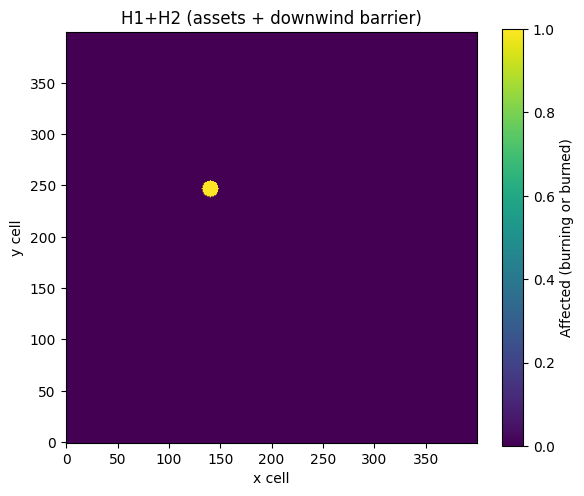

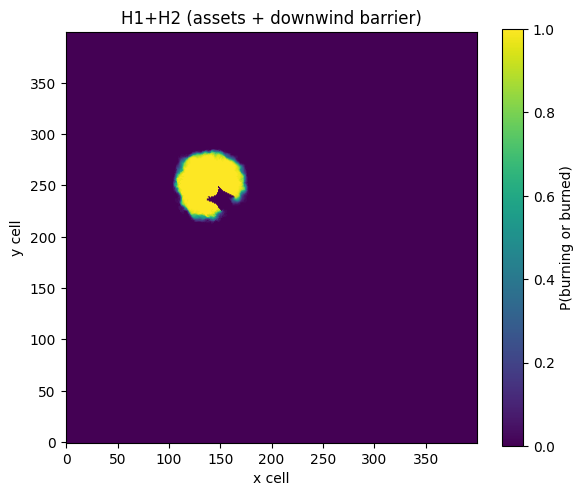

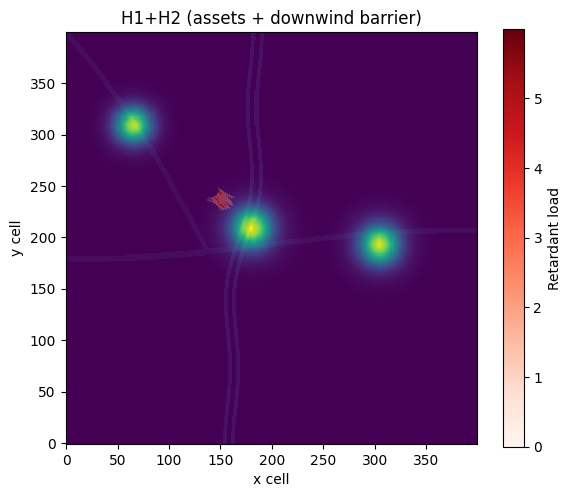

=== H2 downwind-only (long barrier) ===
[Heuristic] eval 001/10 | y=2.32897 | best=2.32897
           (x,y,phi) per drone:
           [[146.     232.       0.7492]
 [147.     231.       0.7498]
 [147.     232.       0.7463]
 [148.     232.       0.75  ]
 [149.     232.       0.6961]
 [150.     232.       0.661 ]
 [151.     233.       0.695 ]
 [152.     233.       0.8465]
 [153.     234.       0.7857]
 [154.     235.       0.8042]
 [154.     235.       0.8734]
 [154.     236.       0.6501]
 [155.     237.       0.7698]
 [155.     237.       0.7975]
 [155.     238.       0.7762]
 [155.     239.       0.6338]
 [155.     241.       0.6695]
 [155.     242.       0.7702]
 [155.     243.       0.7055]
 [156.     240.       0.719 ]]
[Heuristic] eval 010/10 | y=2.33507 | best=2.23249
           (x,y,phi) per drone:
           [[146.     232.       0.7058]
 [147.     232.       0.8743]
 [148.     232.       0.695 ]
 [148.     232.       0.7329]
 [149.     232.       0.8563]
 [150.     232.      

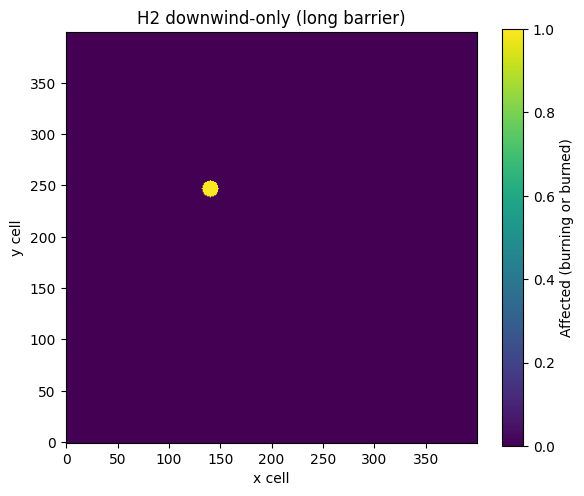

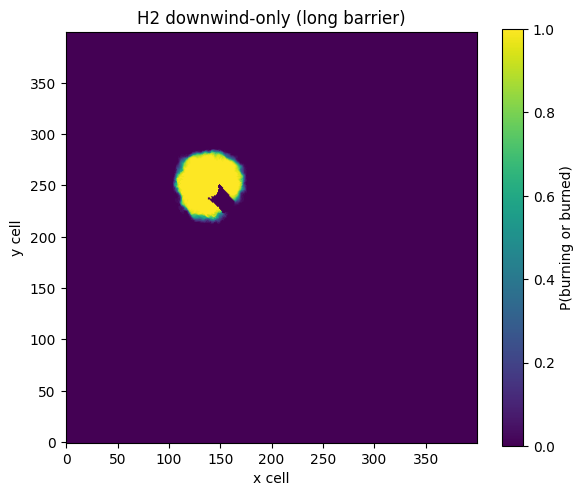

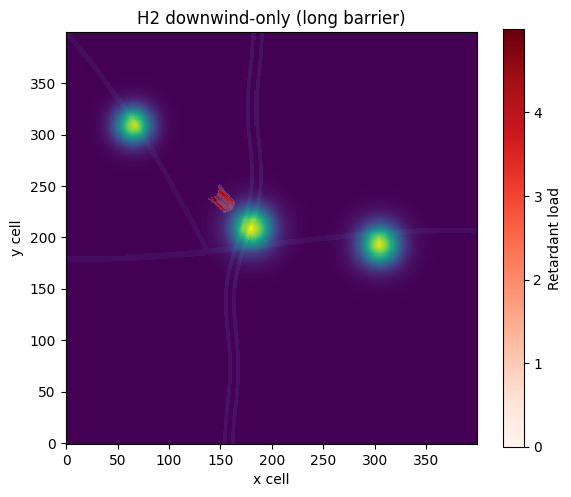

=== H3 shoulder/tangent-only (wind-scaled) ===
[Heuristic] eval 001/10 | y=3.58864 | best=3.58864
           (x,y,phi) per drone:
           [[105.     250.       3.1017]
 [111.     233.       2.2083]
 [111.     233.       2.7991]
 [112.     231.       2.381 ]
 [124.     218.       1.5928]
 [124.     218.       2.2398]
 [132.     215.       1.5193]
 [132.     215.       2.3054]
 [141.     284.       3.975 ]
 [144.     284.       3.9896]
 [147.     213.       0.8831]
 [150.     283.       4.696 ]
 [150.     283.       4.7047]
 [150.     283.       5.5387]
 [156.     280.       4.451 ]
 [171.     269.       5.5771]
 [172.     267.       0.0987]
 [175.     259.       0.1196]
 [175.     259.       5.4158]
 [177.     250.       0.0191]]
[Heuristic] eval 010/10 | y=3.58111 | best=3.53075
           (x,y,phi) per drone:
           [[105.     250.       2.9891]
 [111.     233.       2.3698]
 [111.     233.       2.8084]
 [112.     231.       2.5549]
 [124.     218.       1.6424]
 [124.     218

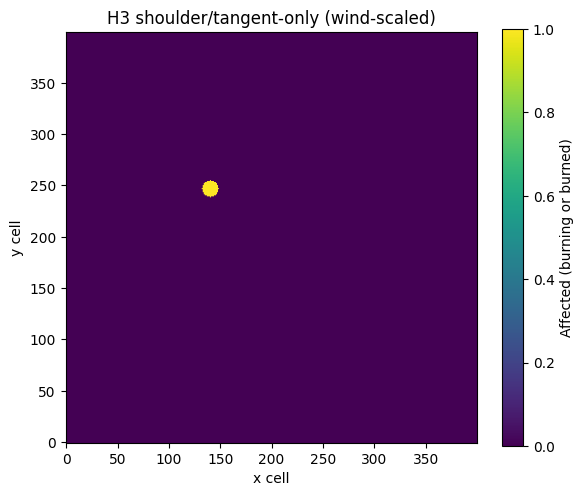

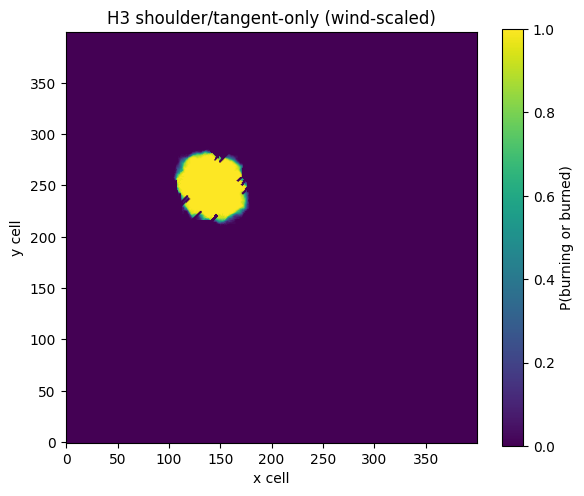

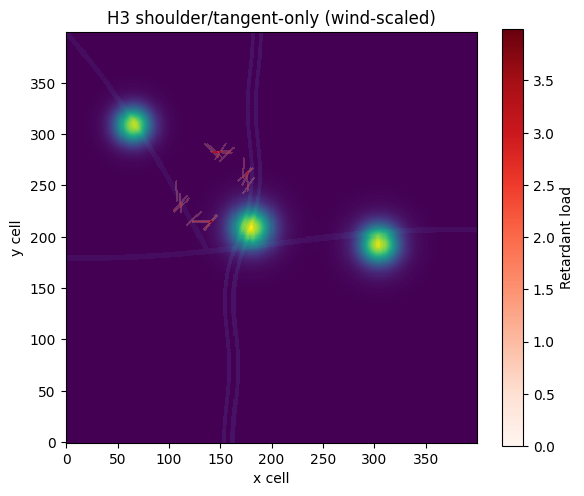

=== H1+H3 + boundary fallback ===
[Heuristic] eval 001/10 | y=1.65815 | best=1.65815
           (x,y,phi) per drone:
           [[112.     231.       2.9728]
 [124.     218.       2.3864]
 [124.     218.       2.4251]
 [137.     230.       2.2127]
 [139.     227.       2.0583]
 [144.     284.       5.561 ]
 [145.     236.       0.8203]
 [147.     224.       1.427 ]
 [147.     236.       0.409 ]
 [147.     237.       0.9601]
 [150.     238.       1.0424]
 [152.     240.       0.5688]
 [153.     241.       0.78  ]
 [156.     280.       5.5994]
 [157.     234.       0.1702]
 [157.     259.       5.8116]
 [159.     245.       0.6783]
 [162.     234.       0.8268]
 [172.     267.       0.092 ]
 [176.     254.       6.2708]]
[Heuristic] eval 010/10 | y=2.16279 | best=1.65815
           (x,y,phi) per drone:
           [[107.     245.       2.455 ]
 [112.     231.       2.3518]
 [115.     228.       2.274 ]
 [123.     244.       2.9172]
 [124.     239.       2.4607]
 [132.     215.       1.610

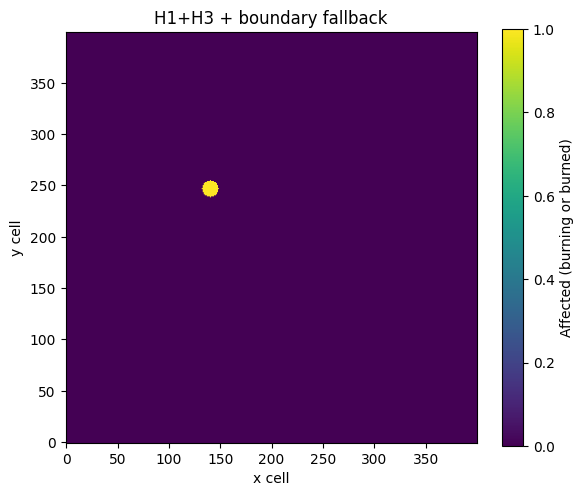

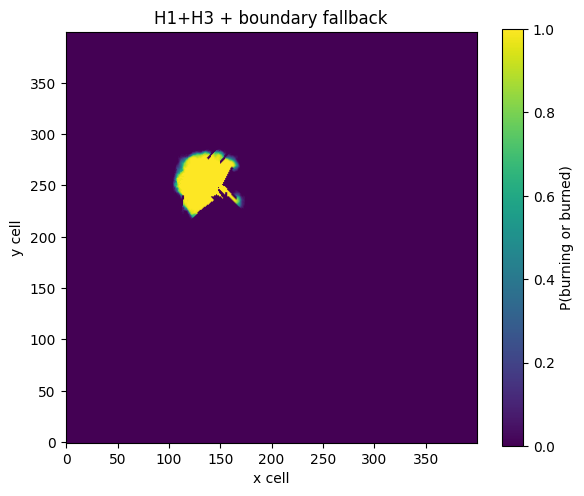

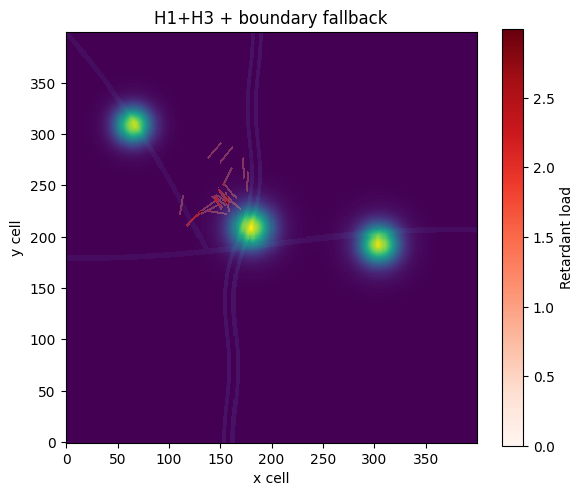

=== Full mix (H1/H2/H3 + boundary + control) ===
[Heuristic] eval 001/10 | y=1.86165 | best=1.86165
           (x,y,phi) per drone:
           [[124.     218.       2.1438]
 [143.     223.       0.7781]
 [144.     284.       5.231 ]
 [144.     284.       5.318 ]
 [146.     236.       0.2376]
 [147.     235.       0.7478]
 [147.     237.       0.6753]
 [147.     270.       4.8999]
 [149.     239.       0.7287]
 [151.     242.       0.8024]
 [152.     240.       0.4941]
 [152.     246.       0.6238]
 [152.     246.       0.7629]
 [154.     232.       0.9366]
 [160.     261.       5.7198]
 [161.     238.       0.196 ]
 [161.     258.       0.2921]
 [165.     240.       0.3956]
 [165.     255.       0.0953]
 [172.     267.       0.2565]]
[Heuristic] eval 010/10 | y=1.80606 | best=1.74043
           (x,y,phi) per drone:
           [[112.     231.       3.2659]
 [129.     228.       1.9455]
 [134.     215.       2.3669]
 [135.     215.       2.3001]
 [142.     228.       0.4415]
 [145.     2

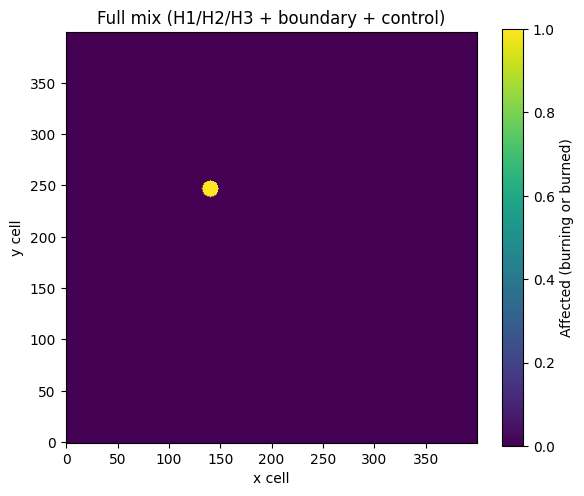

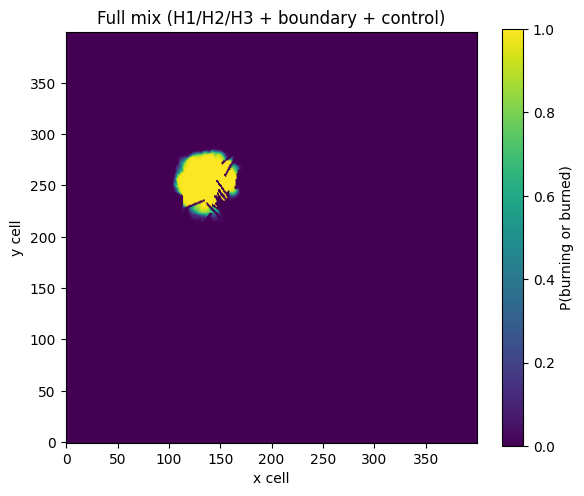

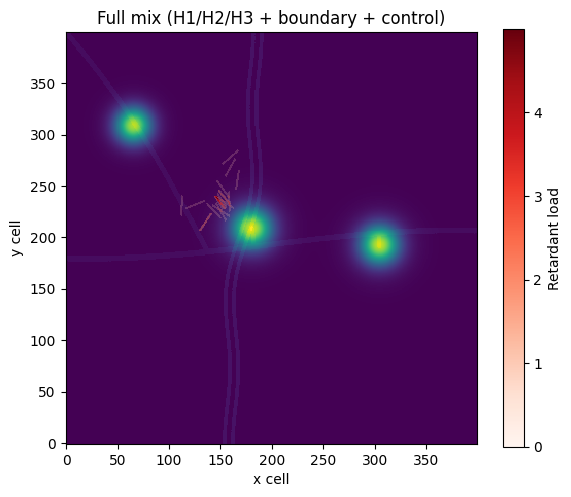

Summary (lower is better):
H1+H3 + boundary fallback: best_y=1.65815
Full mix (H1/H2/H3 + boundary + control): best_y=1.74043
H1+H2+H3 (default): best_y=2.07293
H2 downwind-only (long barrier): best_y=2.23249
H1+H2 (assets + downwind barrier): best_y=2.25972
H1 asset-heavy (tight assets): best_y=2.9157
H3 shoulder/tangent-only (wind-scaled): best_y=3.53075


In [18]:
#Short-time horizon sweep (300s)
n_evals = 10
plot_each = True
n_sims_plot = 50

heuristic_experiments = [
    {
        "name": "H1+H2+H3 (default)",
        "heuristic_kwargs": {},
    },
    {
        "name": "H1 asset-heavy (tight assets)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking"],
            "asset_value_quantile": 0.95,
            "asset_alpha_range": (0.50, 0.85),
            "min_arc_sep_frac": 0.20,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H2 (assets + downwind barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "downwind_blocking"],
            "asset_value_quantile": 0.90,
            "downwind_offset_cells": 8.0,
            "downwind_head_align": 0.50,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
        },
    },
    {
        "name": "H2 downwind-only (long barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["downwind_blocking"],
            "downwind_offset_cells": 10.0,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "downwind_head_align": 0.45,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H3 shoulder/normal-only (wind-scaled)",
        "heuristic_kwargs": {
            "heuristic_modes": ["tangent_blocking"],
            "tangent_offset_cells": 3.0,
            "tangent_wind_scale": 3.0,
            "tangent_orientation": "normal",
            "tangent_shoulder_align": (0.20, 0.70),
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H3 + boundary fallback",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "tangent_blocking", "boundary"],
            "asset_value_quantile": 0.90,
            "tangent_offset_cells": 4.0,
            "value_bias": 0.5,
            "wind_bias": 1.5,
        },
    },
    {
        "name": "Full mix (H1/H2/H3 + boundary + control)",
        "heuristic_kwargs": {
            "heuristic_modes": [
                "fire_asset_blocking",
                "downwind_blocking",
                "tangent_blocking",
                "boundary",
                "control_tie_in",
            ],
            "control_bias": 2.0,
            "value_bias": 0.5,
            "asset_value_quantile": 0.90,
        },
    },
]

results = []
for exp in heuristic_experiments:
    print(f"=== {exp['name']} ===")
    best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=n_evals,
        heuristic_random_frac=0.0,
        heuristic_kwargs=exp["heuristic_kwargs"],
        print_every=n_evals,
    )
    results.append({
        "name": exp["name"],
        "best_y": best_y,
        "best_theta": best_theta,
        "best_params": best_params,
        "y_bests": y_bests,
    })
    if plot_each:
        drop_opt.plot_evolved_firestate(theta=best_theta, n_sims=n_sims_plot, title=exp["name"])

print("Summary (lower is better):")
for row in sorted(results, key=lambda r: r["best_y"]):
    print(f"{row['name']}: best_y={row['best_y']:.6g}")


### Heuristic sweeps (H1/H2/H3)

Run a few short heuristic searches with different intuitive settings to see which configurations
produce the best containment layouts. Adjust `n_evals` or `plot_each` for faster/cheaper runs.


=== H1+H2+H3 (default) ===
[Heuristic] eval 001/20 | y=23.8164 | best=23.8164
           (x,y,phi) per drone:
           [[  8.     103.       2.4188]
 [ 14.      94.       2.587 ]
 [ 24.      89.       2.257 ]
 [ 24.      89.       2.3538]
 [ 25.     111.       3.0092]
 [ 26.     110.       2.4314]
 [ 26.     112.       3.9544]
 [ 27.     113.       3.986 ]
 [ 28.     114.       4.9157]
 [ 29.     113.       5.5845]
 [ 32.     104.       0.7328]
 [ 33.     105.       0.6221]
 [ 34.     106.       0.508 ]
 [ 34.     108.       0.5073]
 [ 35.     106.       0.8015]
 [ 35.     106.       0.9037]
 [ 35.     107.       0.7696]
 [ 37.     132.       5.5446]
 [ 42.     130.       5.3157]
 [ 51.     121.       5.3181]]
[Heuristic] eval 020/20 | y=23.2228 | best=22.2855
           (x,y,phi) per drone:
           [[  8.     103.       2.2959]
 [ 14.      94.       2.0475]
 [ 14.      94.       2.5053]
 [ 24.      89.       2.188 ]
 [ 25.     111.       3.2599]
 [ 26.     110.       2.0442]
 [ 2

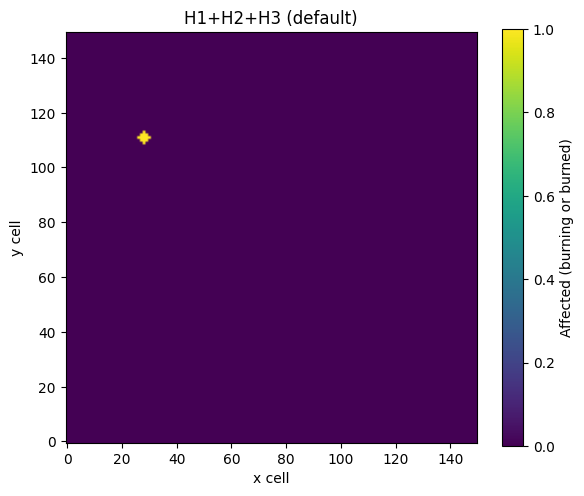

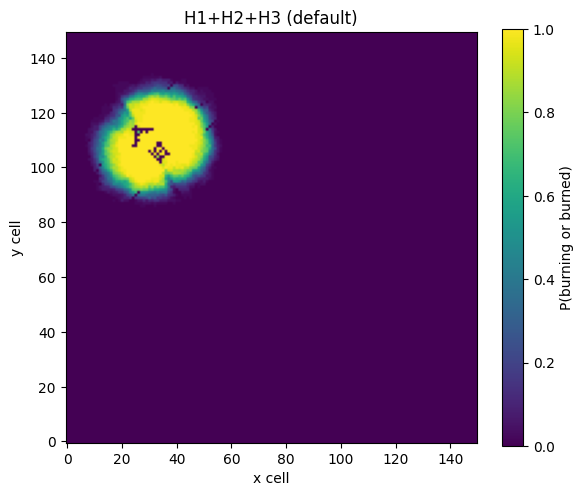

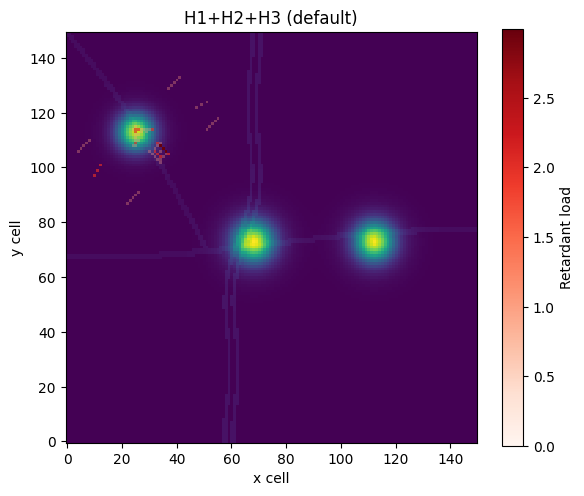

=== H1 asset-heavy (tight assets) ===
[Heuristic] eval 001/20 | y=17.1662 | best=17.1662
           (x,y,phi) per drone:
           [[ 25.     111.       2.8046]
 [ 25.     111.       3.0638]
 [ 26.     110.       1.6679]
 [ 26.     110.       2.3872]
 [ 26.     110.       3.2218]
 [ 26.     112.       2.7489]
 [ 26.     112.       3.0093]
 [ 26.     112.       3.9034]
 [ 26.     112.       4.7139]
 [ 26.     112.       5.0216]
 [ 27.     109.       2.3393]
 [ 27.     113.       2.8526]
 [ 27.     113.       3.1281]
 [ 27.     113.       3.8882]
 [ 27.     113.       4.6777]
 [ 27.     113.       5.0781]
 [ 28.     114.       4.9068]
 [ 29.     113.       4.7698]
 [ 29.     113.       5.5182]
 [ 29.     113.       6.2176]]
[Heuristic] eval 020/20 | y=17.6723 | best=17.1382
           (x,y,phi) per drone:
           [[ 25.     111.       2.7207]
 [ 25.     111.       3.0886]
 [ 26.     110.       1.5174]
 [ 26.     110.       2.3433]
 [ 26.     110.       3.3064]
 [ 26.     112.       2

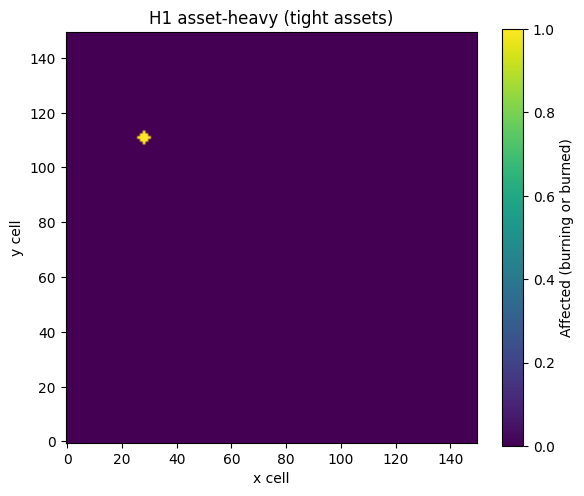

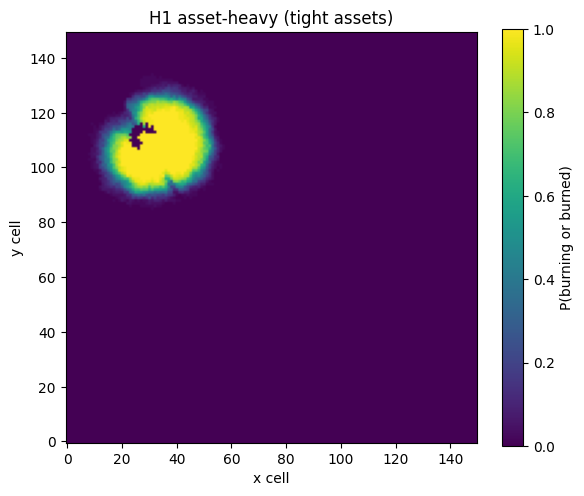

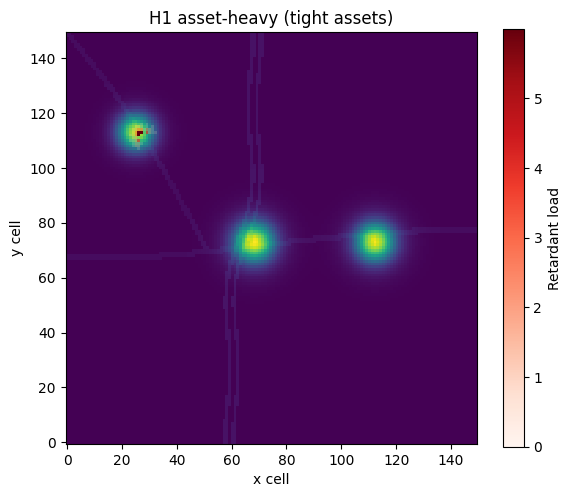

=== H1+H2 (assets + downwind barrier) ===
[Heuristic] eval 001/20 | y=20.8806 | best=20.8806
           (x,y,phi) per drone:
           [[ 25.     111.       3.1617]
 [ 26.     110.       2.5062]
 [ 26.     112.       3.8204]
 [ 26.     112.       4.8337]
 [ 27.     109.       2.2544]
 [ 27.     113.       3.0476]
 [ 27.     113.       3.6147]
 [ 28.     114.       4.903 ]
 [ 29.     113.       5.3637]
 [ 30.     112.       5.5342]
 [ 34.     103.       0.7061]
 [ 34.     103.       0.74  ]
 [ 35.     104.       0.7304]
 [ 35.     104.       0.8044]
 [ 35.     104.       0.8475]
 [ 35.     104.       1.0861]
 [ 36.     105.       0.7989]
 [ 36.     105.       1.0238]
 [ 36.     106.       0.7095]
 [ 36.     106.       1.0692]]
[Heuristic] eval 020/20 | y=22.1337 | best=20.2586
           (x,y,phi) per drone:
           [[ 25.     111.       3.3498]
 [ 26.     110.       2.4811]
 [ 26.     112.       3.8252]
 [ 26.     112.       5.1778]
 [ 27.     109.       2.4292]
 [ 27.     113.    

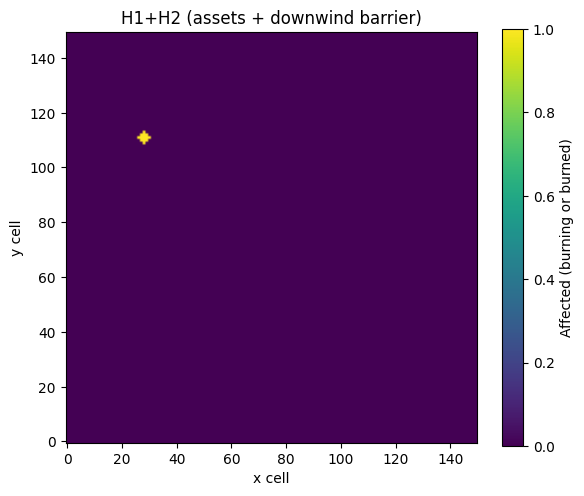

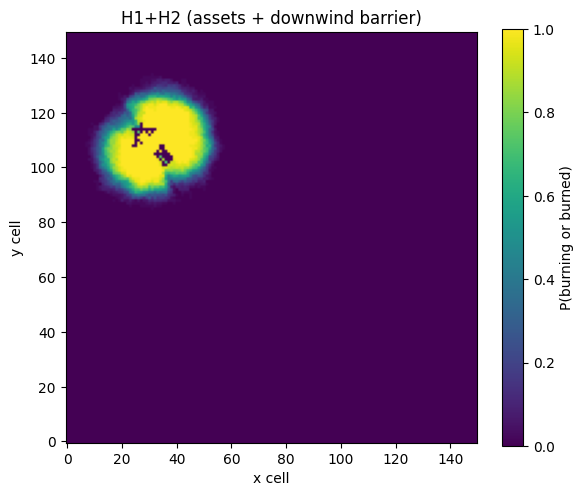

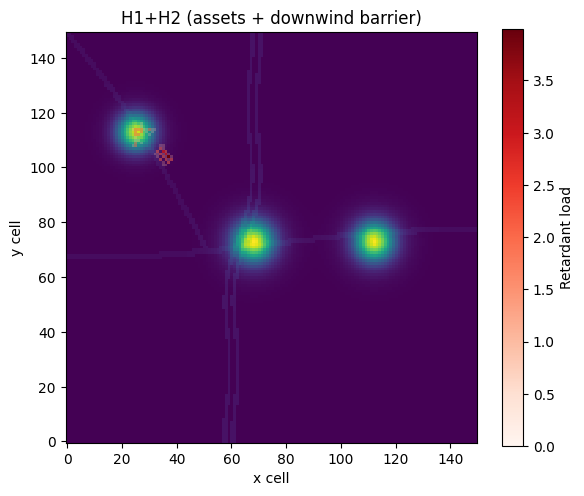

=== H2 downwind-only (long barrier) ===
[Heuristic] eval 001/20 | y=28.4553 | best=28.4553
           (x,y,phi) per drone:
           [[ 35.     101.       0.7559]
 [ 35.     102.       0.7186]
 [ 35.     102.       0.928 ]
 [ 36.     102.       0.6963]
 [ 36.     102.       0.7305]
 [ 36.     102.       0.7884]
 [ 36.     102.       0.868 ]
 [ 36.     103.       0.7843]
 [ 37.     103.       0.6162]
 [ 37.     103.       0.6355]
 [ 37.     103.       0.6553]
 [ 37.     103.       0.7014]
 [ 37.     103.       0.824 ]
 [ 37.     105.       0.6758]
 [ 37.     105.       0.709 ]
 [ 38.     104.       0.6599]
 [ 38.     104.       0.6652]
 [ 38.     104.       0.6762]
 [ 38.     104.       0.7102]
 [ 38.     105.       0.8745]]
[Heuristic] eval 020/20 | y=28.4754 | best=28.3999
           (x,y,phi) per drone:
           [[ 35.     101.       0.6164]
 [ 35.     102.       0.5884]
 [ 35.     102.       0.6574]
 [ 36.     102.       0.6482]
 [ 36.     102.       0.7567]
 [ 36.     102.      

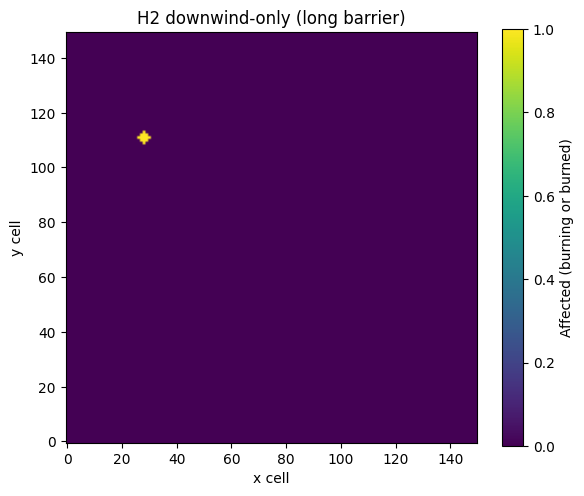

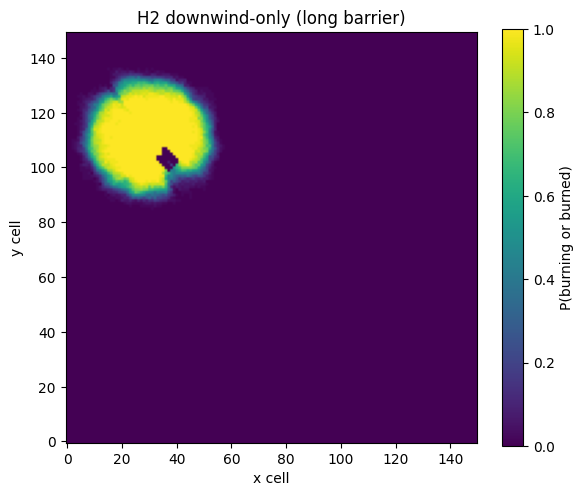

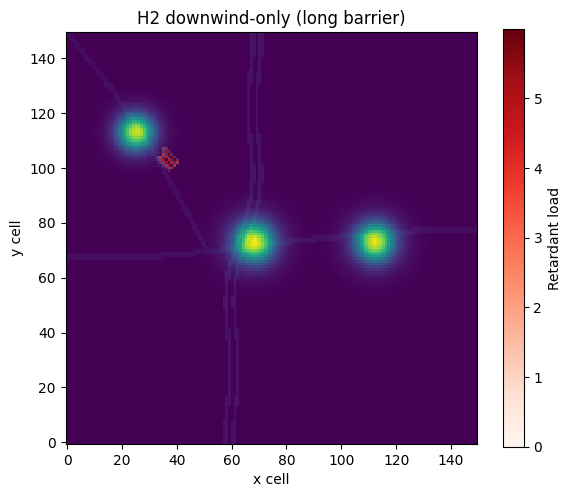

=== H3 shoulder/tangent-only (wind-scaled) ===
[Heuristic] eval 001/20 | y=28.8645 | best=28.8645
           (x,y,phi) per drone:
           [[  6.     108.       2.2039]
 [  6.     108.       2.2297]
 [  6.     108.       2.409 ]
 [  8.     103.       2.2757]
 [  8.     103.       2.38  ]
 [ 16.      93.       2.4137]
 [ 24.      89.       2.2665]
 [ 24.      89.       2.3085]
 [ 24.      89.       2.4618]
 [ 27.     133.       3.7066]
 [ 37.     132.       3.8814]
 [ 37.     132.       5.456 ]
 [ 37.     132.       5.5233]
 [ 42.     130.       5.4265]
 [ 51.     121.       5.5384]
 [ 51.     121.       5.5699]
 [ 52.     119.       5.4399]
 [ 53.     114.       5.5206]
 [ 53.     116.       5.3902]
 [ 53.     116.       5.5397]]
[Heuristic] eval 020/20 | y=28.8697 | best=28.8257
           (x,y,phi) per drone:
           [[  6.     108.       2.3046]
 [  6.     108.       2.3501]
 [  6.     108.       2.4405]
 [  8.     103.       2.3204]
 [ 11.      99.       2.3399]
 [ 16.      93

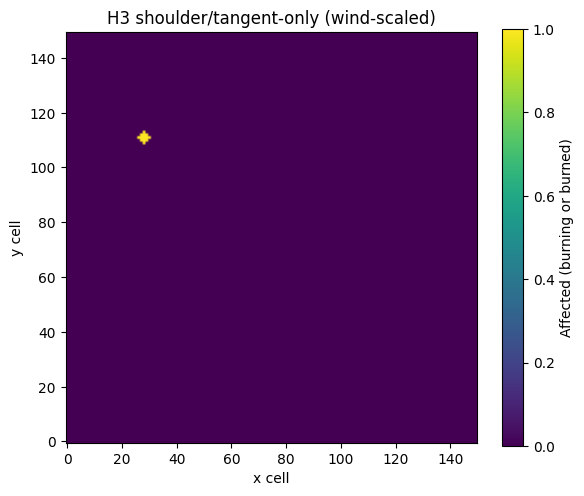

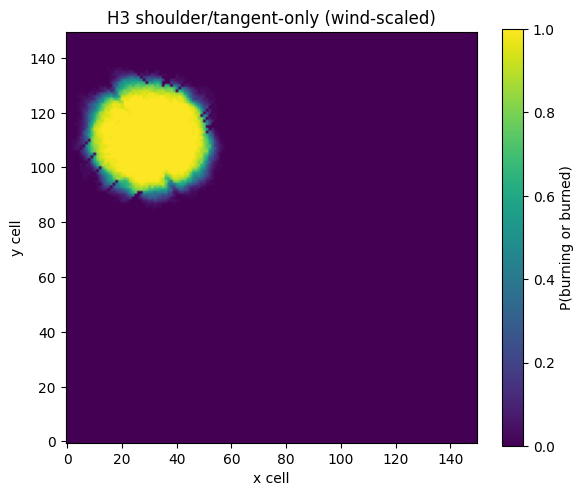

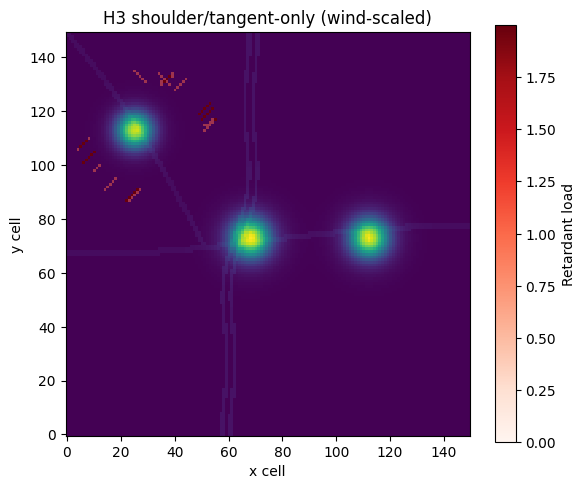

=== H1+H3 + boundary fallback ===
[Heuristic] eval 001/20 | y=25.4255 | best=25.4255
           (x,y,phi) per drone:
           [[  6.     108.       2.1529]
 [  6.     108.       2.5351]
 [ 11.      99.       2.3156]
 [ 24.      89.       2.3403]
 [ 25.     111.       3.3759]
 [ 26.     110.       2.2411]
 [ 26.     112.       3.957 ]
 [ 27.     113.       4.2313]
 [ 28.     114.       5.0348]
 [ 29.      98.       0.5779]
 [ 29.     113.       5.1609]
 [ 33.     121.       6.1817]
 [ 37.     104.       0.8956]
 [ 37.     132.       5.6484]
 [ 39.      99.       0.7474]
 [ 40.     105.       0.5487]
 [ 42.     115.       5.8949]
 [ 43.     118.       5.7274]
 [ 48.     124.       5.4999]
 [ 52.     119.       5.5313]]
[Heuristic] eval 020/20 | y=22.6545 | best=22.6545
           (x,y,phi) per drone:
           [[  6.     108.       2.3931]
 [ 11.      99.       2.2368]
 [ 16.     109.       2.2906]
 [ 21.     100.       2.0847]
 [ 24.      89.       2.4169]
 [ 24.     102.       2.119

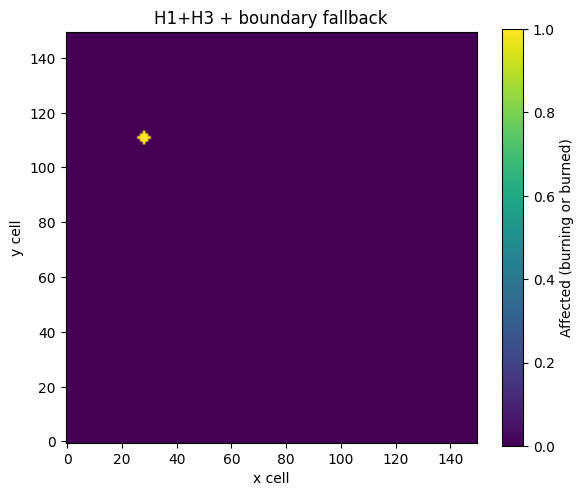

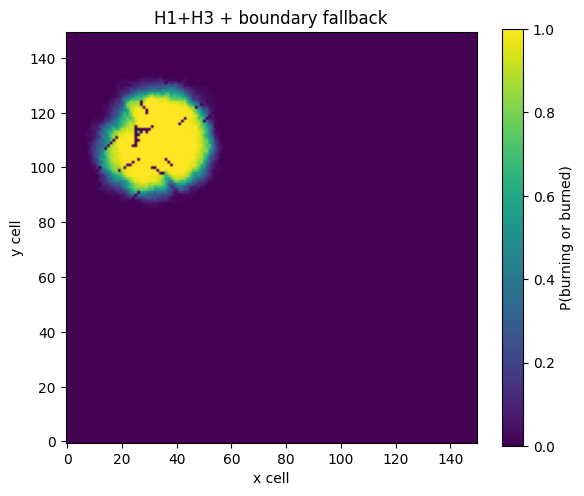

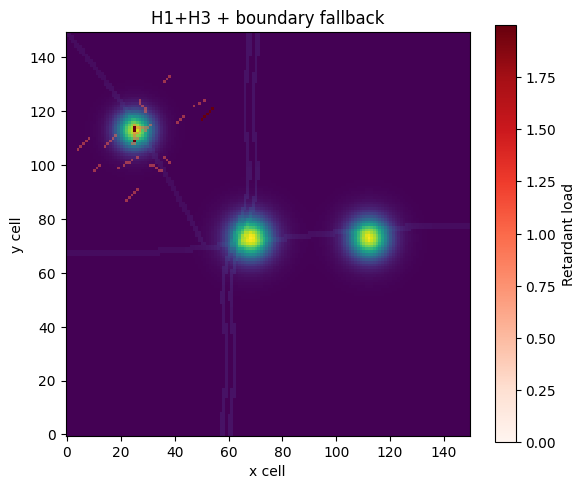

=== Full mix (H1/H2/H3 + boundary + control) ===
[Heuristic] eval 001/20 | y=25.1022 | best=25.1022
           (x,y,phi) per drone:
           [[ 11.      99.       2.3179]
 [ 11.      99.       2.5108]
 [ 25.     111.       3.0417]
 [ 26.     110.       2.9647]
 [ 26.     112.       4.2131]
 [ 27.     113.       3.9912]
 [ 32.      97.       0.798 ]
 [ 33.     104.       0.6948]
 [ 33.     104.       0.8711]
 [ 34.     106.       1.0524]
 [ 35.     107.       0.5788]
 [ 37.     102.       0.8157]
 [ 37.     104.       0.907 ]
 [ 37.     132.       5.7598]
 [ 38.     108.       0.5867]
 [ 40.     122.       5.8726]
 [ 42.      99.       0.7979]
 [ 42.     118.       5.9166]
 [ 43.     106.       0.7981]
 [ 52.     119.       5.4304]]
[Heuristic] eval 020/20 | y=26.0244 | best=25.1022
           (x,y,phi) per drone:
           [[ 16.      93.       2.1968]
 [ 16.      93.       2.3184]
 [ 25.     111.       3.3222]
 [ 26.     110.       2.5343]
 [ 26.     112.       3.8323]
 [ 27.     1

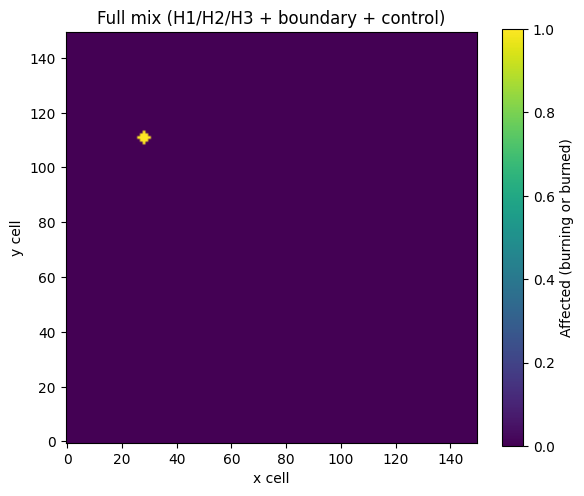

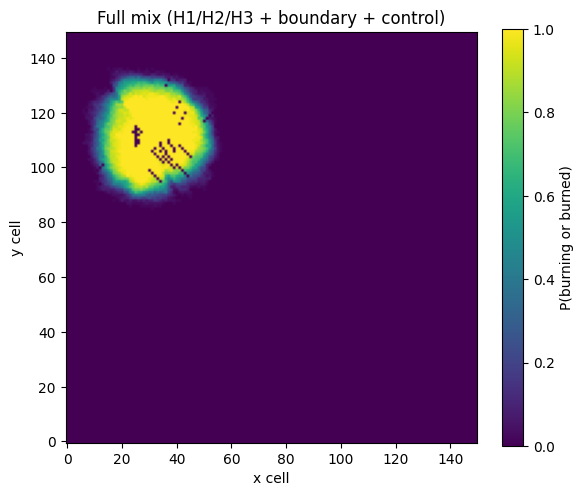

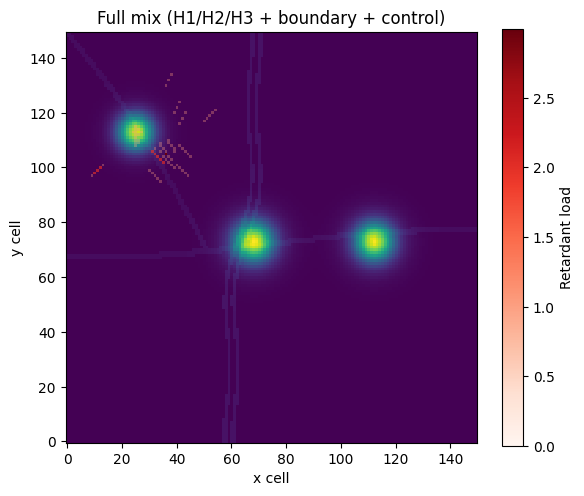

Summary (lower is better):
H1 asset-heavy (tight assets): best_y=17.1382
H1+H2 (assets + downwind barrier): best_y=20.2586
H1+H2+H3 (default): best_y=22.2855
H1+H3 + boundary fallback: best_y=22.6545
Full mix (H1/H2/H3 + boundary + control): best_y=25.1022
H2 downwind-only (long barrier): best_y=28.3999
H3 shoulder/tangent-only (wind-scaled): best_y=28.8257


In [13]:
#Short-time horizon sweep (300s)
n_evals = 20
plot_each = True
n_sims_plot = 50

heuristic_experiments = [
    {
        "name": "H1+H2+H3 (default)",
        "heuristic_kwargs": {},
    },
    {
        "name": "H1 asset-heavy (tight assets)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking"],
            "asset_value_quantile": 0.95,
            "asset_alpha_range": (0.50, 0.85),
            "min_arc_sep_frac": 0.20,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H2 (assets + downwind barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "downwind_blocking"],
            "asset_value_quantile": 0.90,
            "downwind_offset_cells": 8.0,
            "downwind_head_align": 0.50,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
        },
    },
    {
        "name": "H2 downwind-only (long barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["downwind_blocking"],
            "downwind_offset_cells": 10.0,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "downwind_head_align": 0.45,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H3 shoulder/normal-only (wind-scaled)",
        "heuristic_kwargs": {
            "heuristic_modes": ["tangent_blocking"],
            "tangent_offset_cells": 3.0,
            "tangent_wind_scale": 3.0,
            "tangent_orientation": "normal",
            "tangent_shoulder_align": (0.20, 0.70),
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H3 + boundary fallback",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "tangent_blocking", "boundary"],
            "asset_value_quantile": 0.90,
            "tangent_offset_cells": 4.0,
            "value_bias": 0.5,
            "wind_bias": 1.5,
        },
    },
    {
        "name": "Full mix (H1/H2/H3 + boundary + control)",
        "heuristic_kwargs": {
            "heuristic_modes": [
                "fire_asset_blocking",
                "downwind_blocking",
                "tangent_blocking",
                "boundary",
                "control_tie_in",
            ],
            "control_bias": 2.0,
            "value_bias": 0.5,
            "asset_value_quantile": 0.90,
        },
    },
]

results = []
for exp in heuristic_experiments:
    print(f"=== {exp['name']} ===")
    best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=n_evals,
        heuristic_random_frac=0.0,
        heuristic_kwargs=exp["heuristic_kwargs"],
        print_every=n_evals,
    )
    results.append({
        "name": exp["name"],
        "best_y": best_y,
        "best_theta": best_theta,
        "best_params": best_params,
        "y_bests": y_bests,
    })
    if plot_each:
        drop_opt.plot_evolved_firestate(theta=best_theta, n_sims=n_sims_plot, title=exp["name"])

print("Summary (lower is better):")
for row in sorted(results, key=lambda r: r["best_y"]):
    print(f"{row['name']}: best_y={row['best_y']:.6g}")


### Heuristic mode comparison (single-mode)

Run each heuristic mode in isolation to compare placement patterns and objective values.


=== Mode: boundary ===
[Heuristic] eval 001/10 | y=27.9628 | best=27.9628
           (x,y,phi) per drone:
           [[ 14.     104.       1.8799]
 [ 24.      96.       1.797 ]
 [ 27.     100.       2.0366]
 [ 28.      98.       0.6961]
 [ 31.      98.       0.8016]
 [ 32.     103.       0.6644]
 [ 33.      97.       0.7523]
 [ 35.     102.       0.8185]
 [ 35.     123.       5.758 ]
 [ 36.     118.       5.7331]
 [ 37.      97.       1.0752]
 [ 38.     102.       0.9305]
 [ 38.     103.       0.6727]
 [ 38.     105.       0.6264]
 [ 42.     108.       0.4672]
 [ 42.     116.       5.64  ]
 [ 43.     104.       1.1534]
 [ 43.     114.       5.6296]
 [ 44.     118.       5.8035]
 [ 45.     111.       5.6352]]
[Heuristic] eval 010/10 | y=27.465 | best=27.3784
           (x,y,phi) per drone:
           [[ 21.     105.       2.1632]
 [ 22.     126.       4.1922]
 [ 23.      97.       1.9619]
 [ 25.     125.       4.011 ]
 [ 26.     102.       1.8853]
 [ 28.      99.       2.098 ]
 [ 29.   

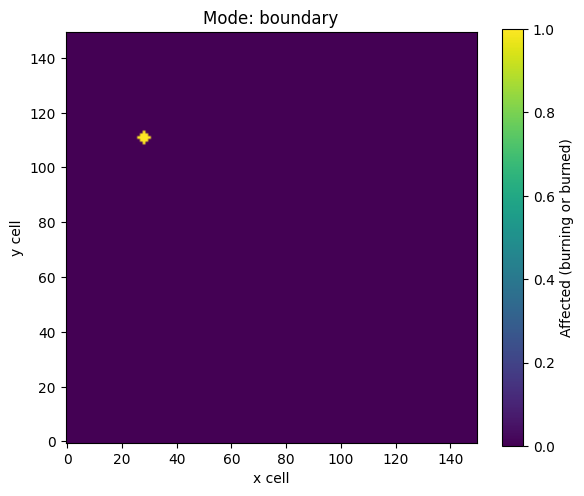

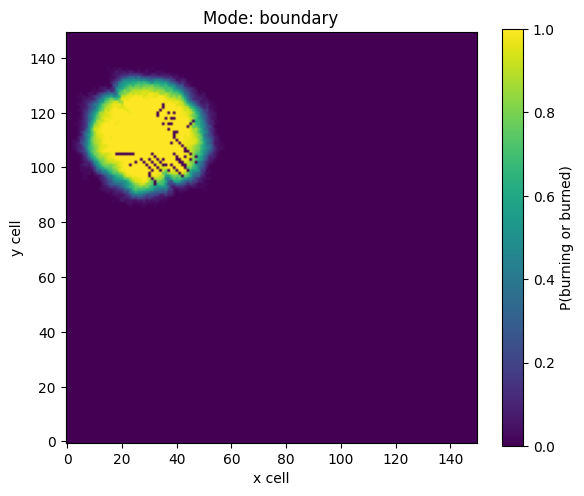

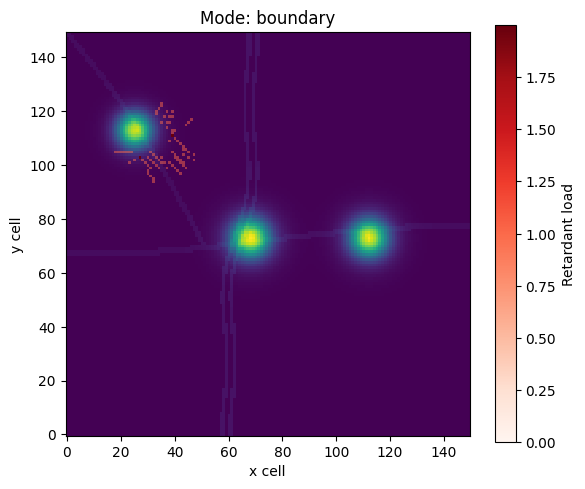

=== Mode: control_tie_in ===
[Heuristic] eval 001/10 | y=27.6325 | best=27.6325
           (x,y,phi) per drone:
           [[ 24.     101.       2.1662]
 [ 25.     101.       1.9402]
 [ 27.     121.       3.9703]
 [ 28.      98.       1.3407]
 [ 30.     101.       0.5226]
 [ 33.     100.       0.9165]
 [ 34.     122.       5.6329]
 [ 35.     103.       0.5652]
 [ 36.      99.       0.7673]
 [ 37.      99.       0.732 ]
 [ 37.     102.       0.9625]
 [ 41.     101.       0.7387]
 [ 41.     108.       1.1029]
 [ 41.     118.       5.7547]
 [ 42.     105.       0.8627]
 [ 43.     116.       5.7817]
 [ 44.     101.       1.0716]
 [ 44.     111.       5.9126]
 [ 45.     105.       0.7713]
 [ 45.     110.       5.4132]]
[Heuristic] eval 010/10 | y=27.7744 | best=27.2353
           (x,y,phi) per drone:
           [[ 19.      98.       2.0202]
 [ 19.     101.       2.1606]
 [ 20.     122.       4.0724]
 [ 25.     102.       2.3879]
 [ 27.      97.       1.9114]
 [ 31.      96.       0.8286]
 [

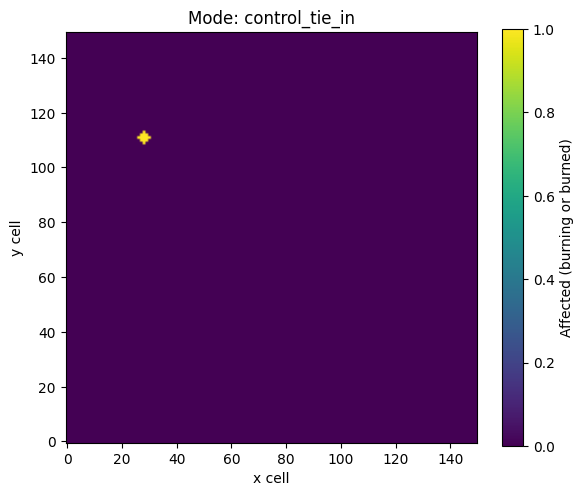

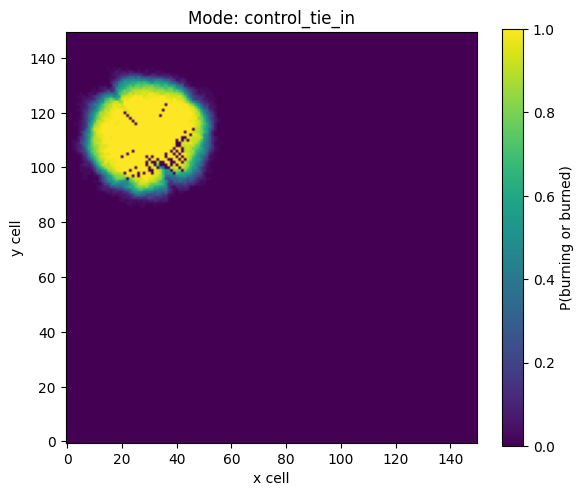

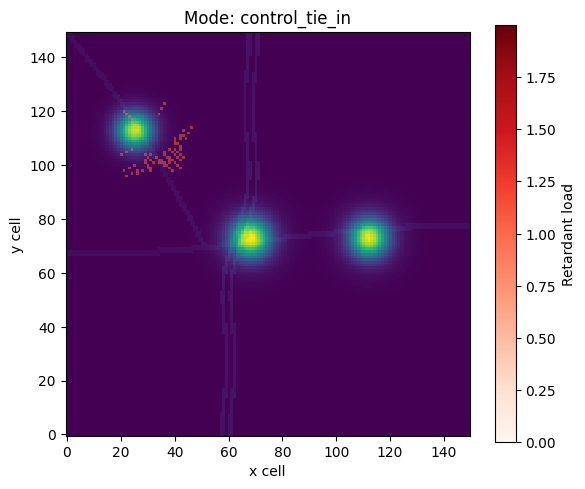

=== Mode: contingency ===
[Heuristic] eval 001/10 | y=28.3193 | best=28.3193
           (x,y,phi) per drone:
           [[  7.     108.       1.917 ]
 [ 14.     102.       2.0606]
 [ 21.      95.       2.2073]
 [ 27.      92.       1.9898]
 [ 33.      93.       0.7216]
 [ 35.      96.       0.95  ]
 [ 40.      94.       0.3877]
 [ 40.      96.       0.7368]
 [ 41.      98.       0.7031]
 [ 44.     122.       6.0456]
 [ 45.      96.       0.7666]
 [ 45.      99.       0.7208]
 [ 45.     119.       5.7451]
 [ 46.     114.       5.8107]
 [ 48.     109.       5.5897]
 [ 50.     100.       0.5062]
 [ 50.     103.       1.2227]
 [ 50.     117.       5.9023]
 [ 51.     106.       0.801 ]
 [ 51.     112.       5.955 ]]
[Heuristic] eval 010/10 | y=28.4559 | best=28.1642
           (x,y,phi) per drone:
           [[  8.     108.       1.9626]
 [ 11.     124.       4.0229]
 [ 18.      94.       1.9689]
 [ 21.     128.       4.0478]
 [ 30.      91.       0.6804]
 [ 32.      90.       0.8902]
 [ 35

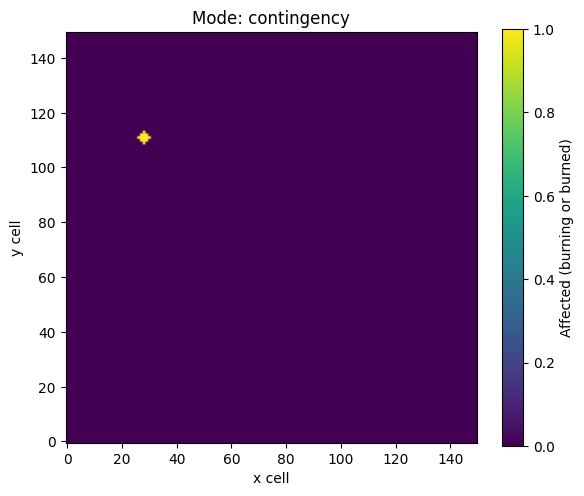

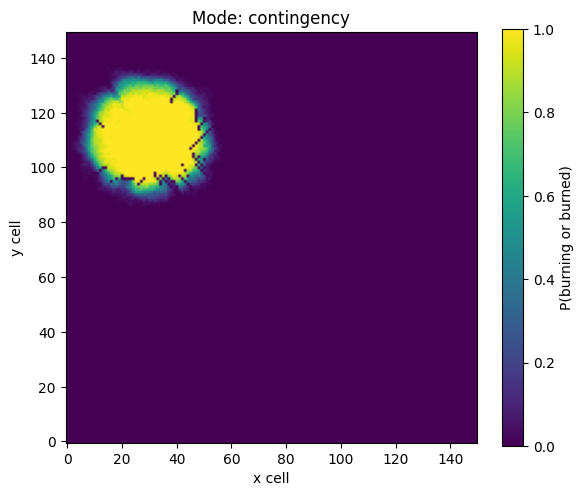

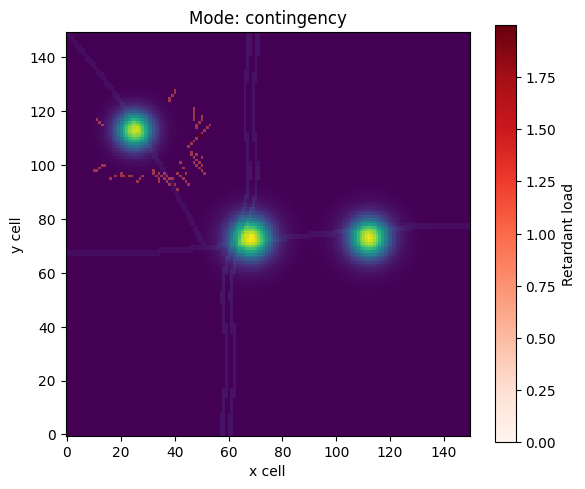

=== Mode: point_protection ===
[Heuristic] eval 001/10 | y=26.4463 | best=26.4463
           (x,y,phi) per drone:
           [[ 22.     117.       2.0715]
 [ 22.     117.       5.6966]
 [ 23.     110.       5.4833]
 [ 25.     111.       1.4853]
 [ 28.     114.       0.1464]
 [ 46.      94.       0.7986]
 [ 46.      94.       0.8346]
 [ 49.      96.       0.7217]
 [ 49.      96.       0.7581]
 [ 49.      96.       0.7598]
 [ 49.      96.       0.7947]
 [ 50.      97.       0.5906]
 [ 50.      97.       0.6049]
 [ 50.      97.       0.6194]
 [ 50.      97.       0.635 ]
 [ 50.      97.       0.6873]
 [ 50.      97.       0.7234]
 [ 53.     104.       0.5602]
 [ 53.     104.       0.5728]
 [ 53.     104.       0.5779]]
[Heuristic] eval 010/10 | y=26.4463 | best=26.4463
           (x,y,phi) per drone:
           [[ 22.     117.       2.0715]
 [ 22.     117.       5.6966]
 [ 23.     110.       5.4833]
 [ 25.     111.       1.4853]
 [ 28.     114.       0.1464]
 [ 46.      94.       0.7986]


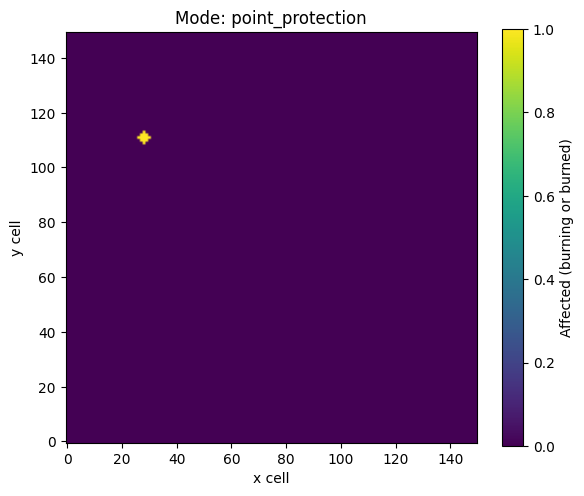

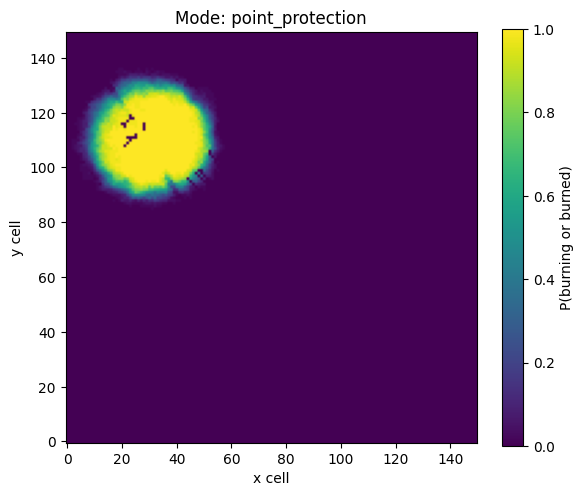

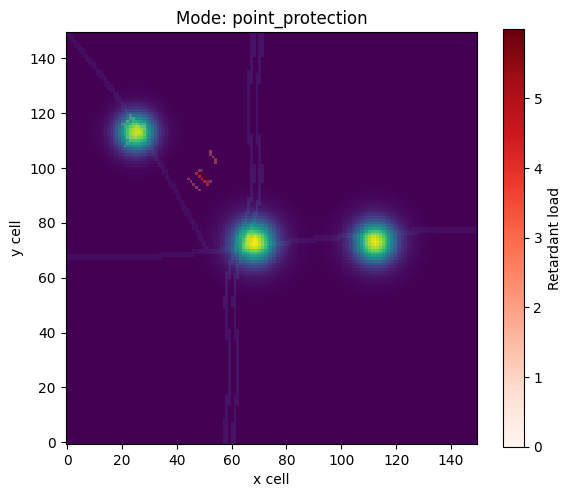

=== Mode: head_flank ===
[Heuristic] eval 001/10 | y=27.6163 | best=27.6163
           (x,y,phi) per drone:
           [[ 17.     106.       1.8921]
 [ 18.     104.       2.2408]
 [ 18.     110.       2.219 ]
 [ 20.     120.       3.9285]
 [ 22.     100.       1.8426]
 [ 24.      96.       1.8976]
 [ 27.     101.       1.8718]
 [ 29.     100.       0.7732]
 [ 30.     101.       0.6817]
 [ 32.      97.       0.5787]
 [ 34.     100.       0.4573]
 [ 34.     126.       5.9862]
 [ 36.     104.       1.071 ]
 [ 37.     101.       0.8365]
 [ 37.     102.       0.5836]
 [ 37.     120.       5.535 ]
 [ 40.     108.       0.9875]
 [ 40.     116.       5.8367]
 [ 42.     119.       5.9576]
 [ 43.     105.       0.9538]]
[Heuristic] eval 010/10 | y=27.452 | best=27.2336
           (x,y,phi) per drone:
           [[ 15.     112.       2.1225]
 [ 17.     121.       3.6752]
 [ 20.     100.       1.8539]
 [ 23.     101.       2.158 ]
 [ 24.      98.       1.6932]
 [ 25.      96.       1.9681]
 [ 26. 

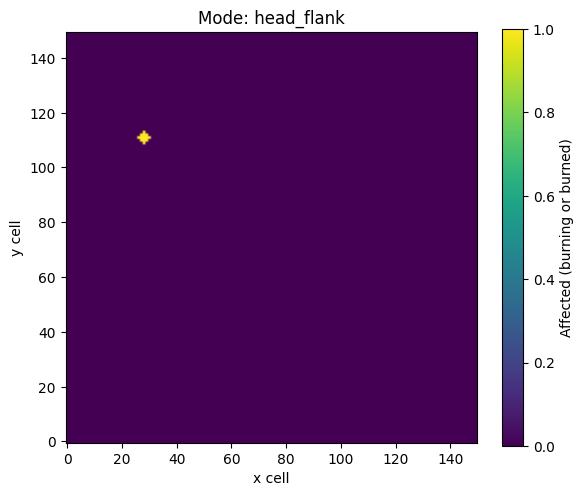

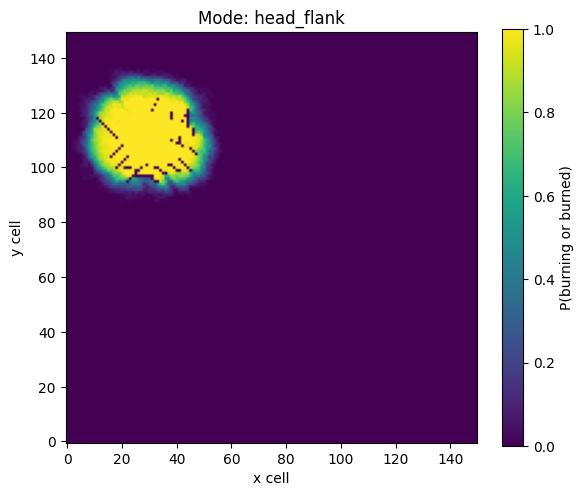

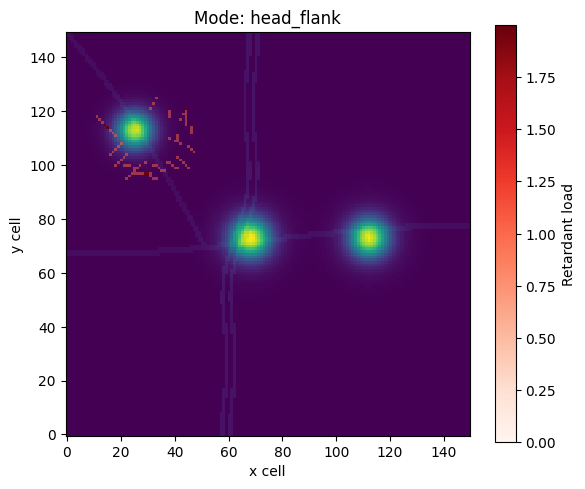

=== Mode: confine ===
[Heuristic] eval 001/10 | y=25.7002 | best=25.7002
           (x,y,phi) per drone:
           [[ 15.     113.       3.5343]
 [ 16.     121.       3.5343]
 [ 18.     111.       3.5343]
 [ 19.     119.       3.5343]
 [ 21.     110.       3.5343]
 [ 23.     118.       3.5343]
 [ 24.     109.       3.5343]
 [ 26.     117.       3.5343]
 [ 28.     107.       3.5343]
 [ 29.     115.       3.5343]
 [ 31.     106.       3.5343]
 [ 32.     114.       3.5343]
 [ 34.     105.       3.5343]
 [ 36.     113.       3.5343]
 [ 37.     103.       3.5343]
 [ 39.     111.       3.5343]
 [ 41.     102.       3.5343]
 [ 42.     110.       3.5343]
 [ 44.     101.       3.5343]
 [ 45.     109.       3.5343]]
[Heuristic] eval 010/10 | y=25.7002 | best=25.7002
           (x,y,phi) per drone:
           [[ 15.     113.       3.5343]
 [ 16.     121.       3.5343]
 [ 18.     111.       3.5343]
 [ 19.     119.       3.5343]
 [ 21.     110.       3.5343]
 [ 23.     118.       3.5343]
 [ 24.   

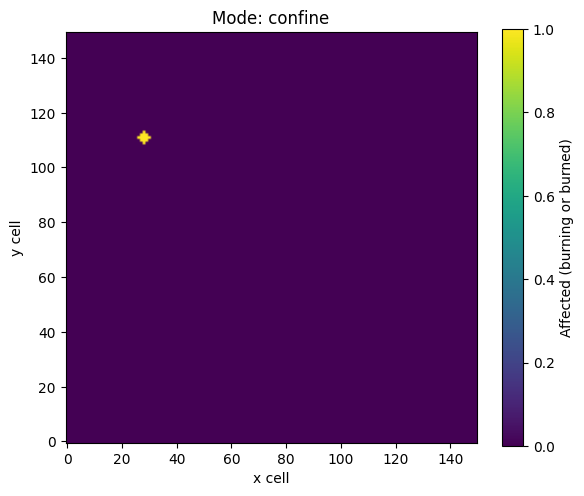

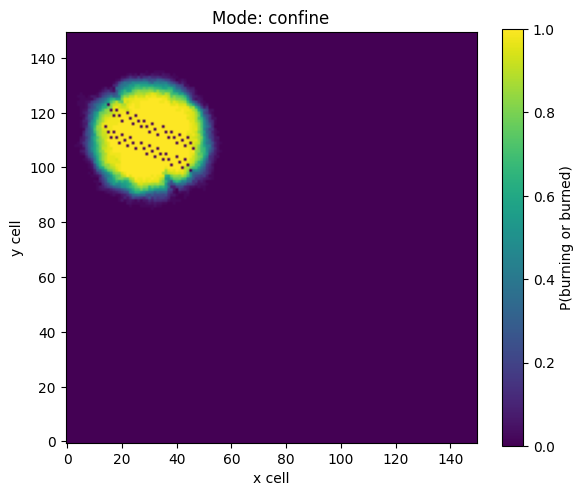

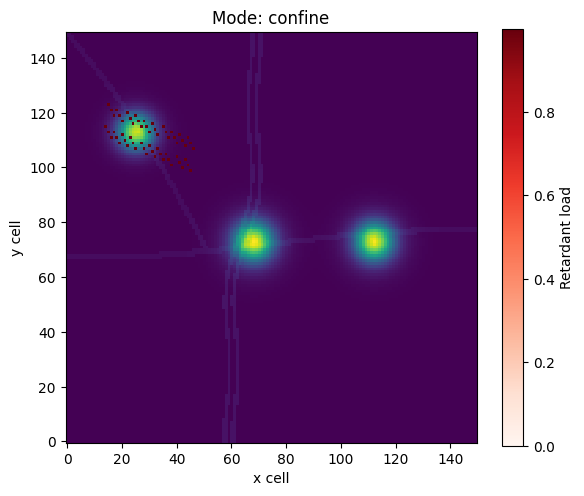

=== Mode: fire_asset_blocking ===
[Heuristic] eval 001/10 | y=18.5448 | best=18.5448
           (x,y,phi) per drone:
           [[ 25.     111.       2.9814]
 [ 25.     111.       3.0398]
 [ 25.     111.       3.6156]
 [ 26.     110.       1.4131]
 [ 26.     110.       2.4041]
 [ 26.     110.       3.2354]
 [ 26.     112.       2.9693]
 [ 26.     112.       3.9873]
 [ 26.     112.       4.7978]
 [ 26.     112.       4.9906]
 [ 27.     109.       2.3195]
 [ 27.     113.       2.9723]
 [ 27.     113.       4.1001]
 [ 27.     113.       4.6629]
 [ 28.     114.       4.6837]
 [ 29.     109.       0.8162]
 [ 29.     113.       0.016 ]
 [ 29.     113.       4.601 ]
 [ 29.     113.       5.7391]
 [ 30.     112.       5.6353]]
[Heuristic] eval 010/10 | y=18.022 | best=17.0939
           (x,y,phi) per drone:
           [[ 25.     111.       2.7955]
 [ 25.     111.       2.8062]
 [ 25.     111.       3.7806]
 [ 26.     110.       1.658 ]
 [ 26.     110.       2.7185]
 [ 26.     110.       3.2928

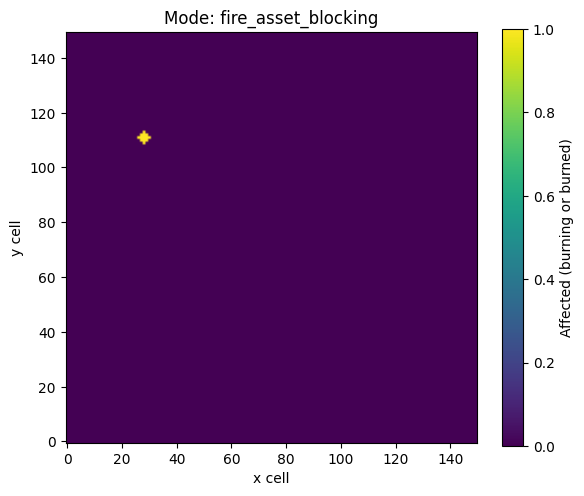

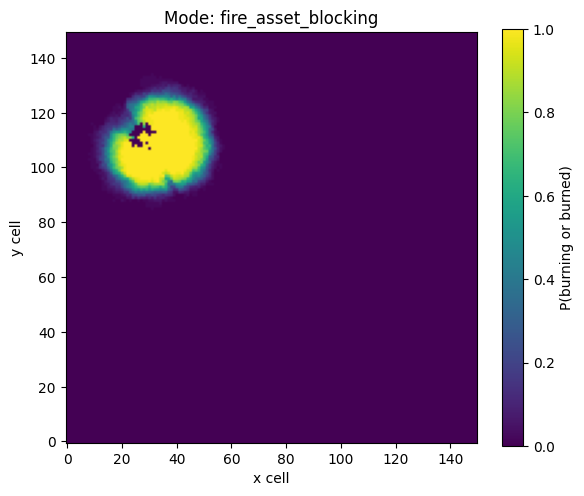

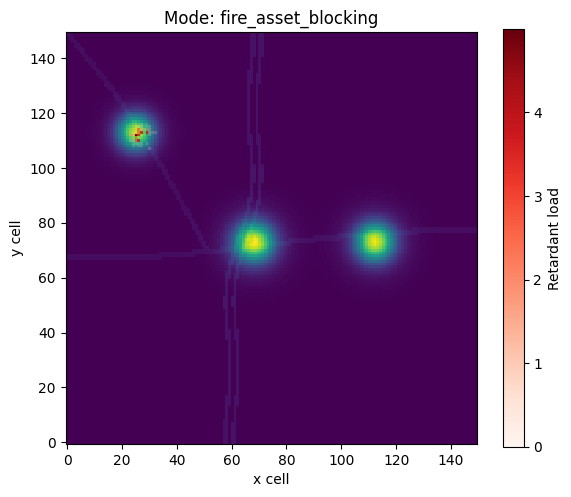

=== Mode: downwind_blocking ===
[Heuristic] eval 001/10 | y=28.4882 | best=28.4882
           (x,y,phi) per drone:
           [[ 33.     103.       0.6543]
 [ 34.     103.       0.4873]
 [ 34.     103.       0.802 ]
 [ 34.     103.       0.8666]
 [ 34.     103.       0.8922]
 [ 34.     103.       0.9018]
 [ 34.     103.       0.9385]
 [ 35.     104.       0.6443]
 [ 35.     104.       0.7338]
 [ 35.     104.       0.8741]
 [ 35.     104.       1.0764]
 [ 36.     105.       0.6553]
 [ 36.     105.       0.6733]
 [ 36.     105.       0.745 ]
 [ 36.     105.       0.7609]
 [ 36.     106.       0.6254]
 [ 36.     106.       0.6368]
 [ 36.     106.       0.7013]
 [ 36.     106.       0.902 ]
 [ 37.     105.       0.5573]]
[Heuristic] eval 010/10 | y=28.4401 | best=28.3222
           (x,y,phi) per drone:
           [[ 33.     103.       0.6159]
 [ 34.     103.       0.1871]
 [ 34.     103.       0.5093]
 [ 34.     103.       0.7327]
 [ 34.     103.       0.7617]
 [ 34.     103.       0.9992]

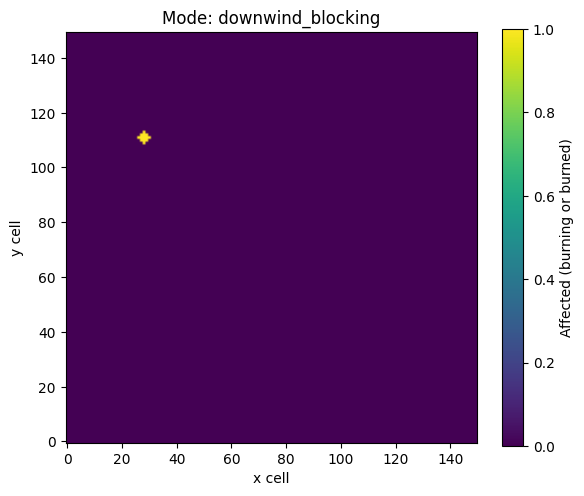

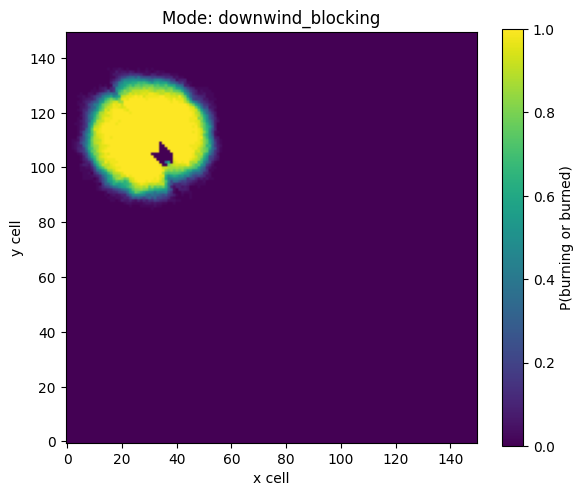

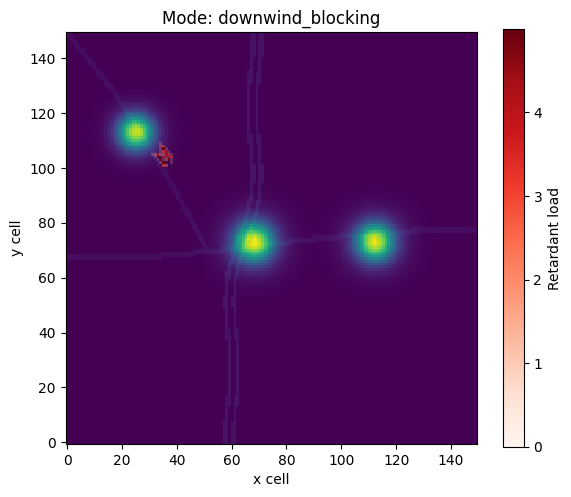

=== Mode: tangent_blocking ===
[Heuristic] eval 001/10 | y=28.8469 | best=28.8469
           (x,y,phi) per drone:
           [[  6.     108.       2.3671]
 [  8.     103.       2.4574]
 [  8.     103.       2.4725]
 [ 11.      99.       2.5872]
 [ 14.      94.       2.2803]
 [ 16.      93.       2.1986]
 [ 24.      89.       2.2399]
 [ 24.      89.       2.5918]
 [ 24.      89.       2.5926]
 [ 33.     132.       4.0735]
 [ 37.     132.       5.4474]
 [ 37.     132.       5.4572]
 [ 39.     131.       5.6363]
 [ 42.     130.       5.6874]
 [ 48.     124.       5.331 ]
 [ 49.     123.       5.6679]
 [ 51.     121.       5.6272]
 [ 51.     121.       5.7756]
 [ 52.     119.       5.3763]
 [ 53.     116.       5.4772]]
[Heuristic] eval 010/10 | y=28.8169 | best=28.7917
           (x,y,phi) per drone:
           [[  6.     108.       2.1377]
 [  8.     103.       2.3537]
 [  8.     103.       2.5402]
 [ 11.      99.       2.5949]
 [ 14.      94.       2.3033]
 [ 16.      93.       2.0732]


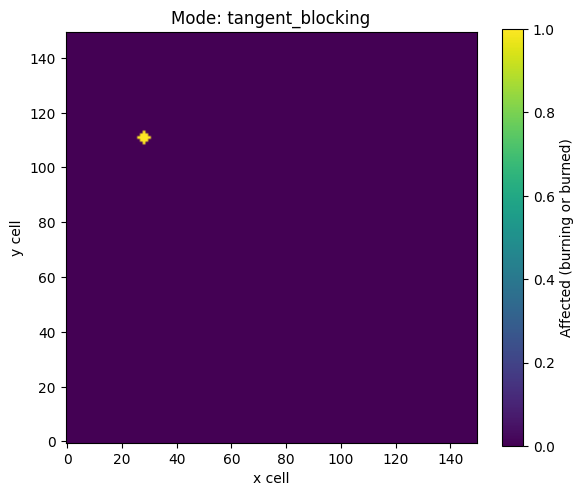

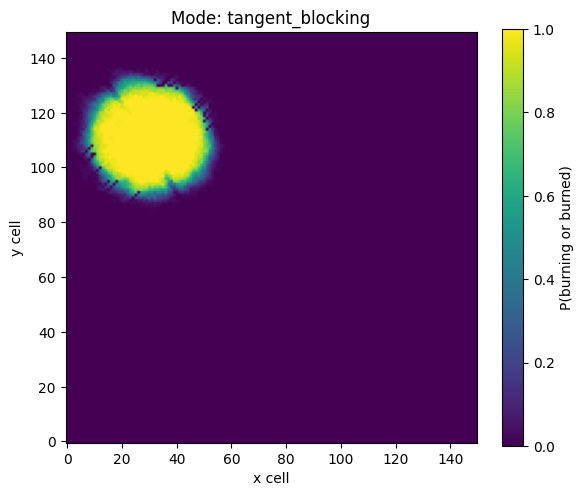

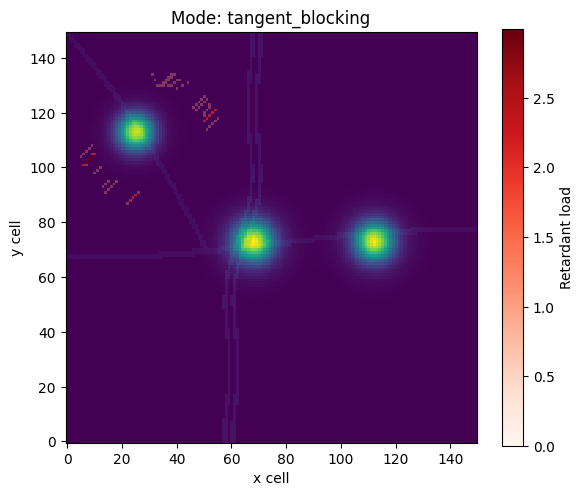

Mode summary (lower is better):
fire_asset_blocking: best_y=17.0939
confine: best_y=25.7002
point_protection: best_y=26.4463
head_flank: best_y=27.2336
control_tie_in: best_y=27.2353
boundary: best_y=27.3784
contingency: best_y=28.1642
downwind_blocking: best_y=28.3222
tangent_blocking: best_y=28.7917


In [14]:
# Single-mode comparison
n_evals_mode = 10
plot_each_mode = True
n_sims_plot_mode = 50

mode_experiments = [
    {"name": "boundary", "mode": "boundary", "kwargs": {}},
    {"name": "control_tie_in", "mode": "control_tie_in", "kwargs": {"control_bias": 2.0}},
    {"name": "contingency", "mode": "contingency", "kwargs": {"contingency_alpha_range": (0.7, 0.95)}},
    {"name": "point_protection", "mode": "point_protection", "kwargs": {"point_value_quantile": 0.9}},
    {"name": "head_flank", "mode": "head_flank", "kwargs": {"head_frac": 0.5, "flank_frac": 0.3, "back_frac": 0.2}},
    {"name": "confine", "mode": "confine", "kwargs": {"confine_offset_cells": 4.0}},
    {"name": "fire_asset_blocking", "mode": "fire_asset_blocking", "kwargs": {"asset_value_quantile": 0.9}},
    {"name": "downwind_blocking", "mode": "downwind_blocking", "kwargs": {"downwind_offset_cells": 8.0, "downwind_orientation": "perp", "downwind_min_arc_sep_frac": 0.25, "downwind_layer_spacing_cells": 4.0}},
    {"name": "tangent_blocking (normal)", "mode": "tangent_blocking", "kwargs": {"tangent_offset_cells": 3.0, "tangent_orientation": "normal"}},
]

mode_results = []
for exp in mode_experiments:
    print(f"=== Mode: {exp['name']} ===")
    heuristic_kwargs = {"heuristic_modes": [exp["mode"]]} 
    heuristic_kwargs.update(exp.get("kwargs", {}))
    best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=n_evals_mode,
        heuristic_random_frac=0.0,
        heuristic_kwargs=heuristic_kwargs,
        print_every=n_evals_mode,
    )
    mode_results.append({"name": exp["name"], "best_y": best_y, "best_theta": best_theta})
    if plot_each_mode:
        drop_opt.plot_evolved_firestate(theta=best_theta, n_sims=n_sims_plot_mode, title=f"Mode: {exp['name']}")

print("Mode summary (lower is better):")
for row in sorted(mode_results, key=lambda r: r["best_y"]):
    print(f"{row['name']}: best_y={row['best_y']:.6g}")


=== H1+H2+H3 (default) ===
[Heuristic] Search grid set up with 4817 valid cells in grid.


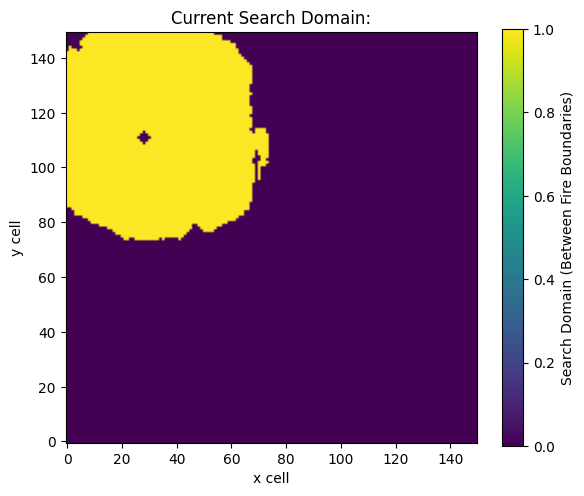

[Heuristic] eval 001/10 | y=115.991 | best=115.991
           (x,y,phi) per drone:
           [[  0.      94.       2.5194]
 [ 13.      81.       2.3648]
 [ 25.     111.       2.9374]
 [ 26.     110.       2.2807]
 [ 26.     112.       3.956 ]
 [ 27.     113.       4.0885]
 [ 28.     114.       4.6673]
 [ 29.     113.       5.3713]
 [ 32.     104.       0.7654]
 [ 33.     105.       0.8757]
 [ 34.     105.       0.9316]
 [ 34.     108.       0.3718]
 [ 34.     145.       3.8115]
 [ 35.     106.       0.6485]
 [ 35.     106.       0.9868]
 [ 35.     107.       0.8669]
 [ 45.     140.       5.2673]
 [ 56.     129.       5.8158]
 [ 57.     129.       5.5307]
 [ 61.     119.       5.8473]]
[Heuristic] eval 010/10 | y=116.142 | best=115.991
           (x,y,phi) per drone:
           [[  0.      99.       2.109 ]
 [  9.      83.       2.2118]
 [  9.      83.       2.2958]
 [ 21.      78.       2.3552]
 [ 25.     111.       3.1768]
 [ 26.     110.       2.3395]
 [ 26.     112.       4.1943]
 

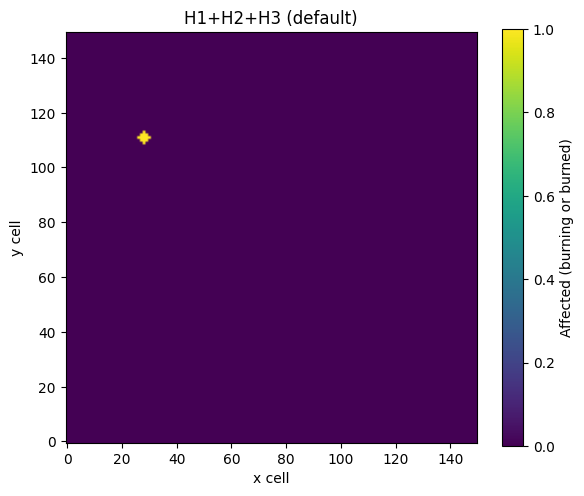

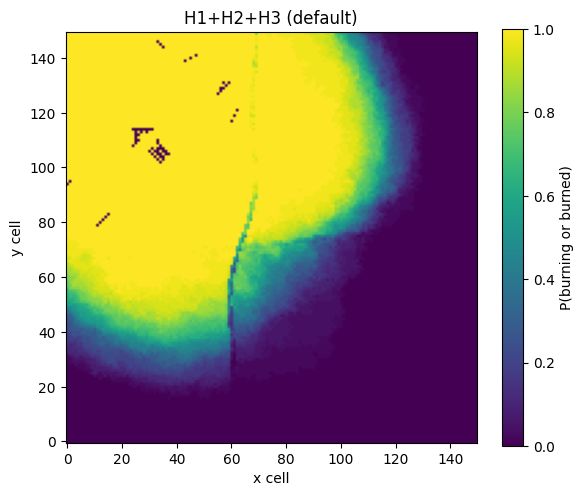

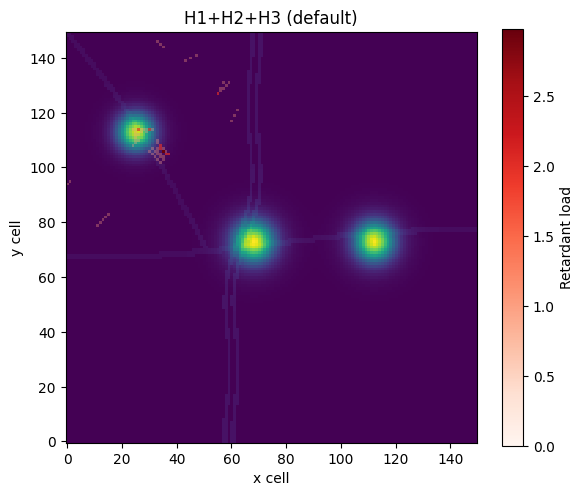

=== H1 asset-heavy (tight assets) ===
[Heuristic] eval 001/10 | y=115.778 | best=115.778
           (x,y,phi) per drone:
           [[ 25.     111.       2.8243]
 [ 25.     111.       3.0164]
 [ 26.     110.       1.5892]
 [ 26.     110.       2.4601]
 [ 26.     110.       3.26  ]
 [ 26.     112.       2.8272]
 [ 26.     112.       3.1059]
 [ 26.     112.       3.8221]
 [ 26.     112.       4.6876]
 [ 26.     112.       4.7189]
 [ 27.     109.       2.3718]
 [ 27.     113.       2.8036]
 [ 27.     113.       3.0874]
 [ 27.     113.       4.0911]
 [ 27.     113.       4.6707]
 [ 27.     113.       5.0224]
 [ 28.     114.       4.7615]
 [ 29.     113.       4.5702]
 [ 29.     113.       5.5236]
 [ 29.     113.       6.2361]]
[Heuristic] eval 010/10 | y=115.394 | best=115.317
           (x,y,phi) per drone:
           [[ 25.     111.       2.9102]
 [ 25.     111.       3.0916]
 [ 26.     110.       1.6894]
 [ 26.     110.       2.4236]
 [ 26.     110.       3.1401]
 [ 26.     112.       2

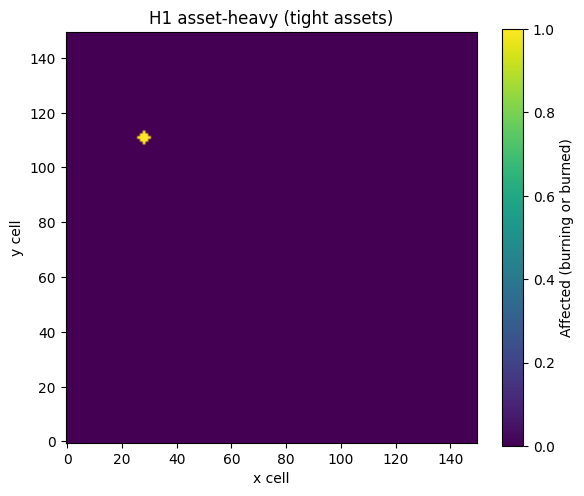

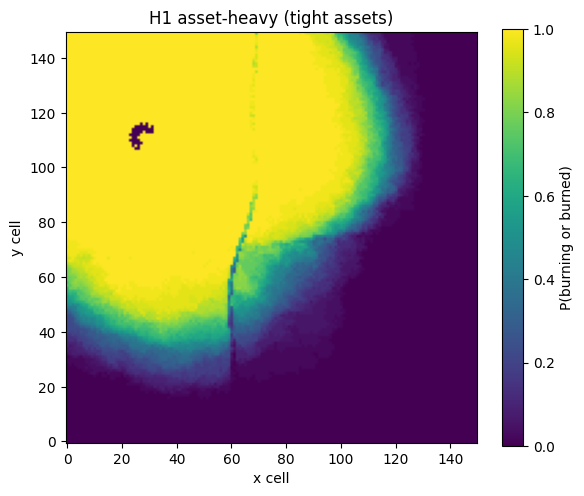

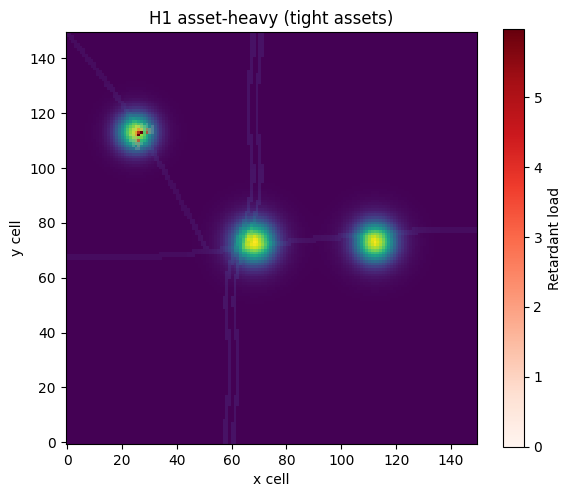

=== H1+H2 (assets + downwind barrier) ===
[Heuristic] eval 001/10 | y=115.725 | best=115.725
           (x,y,phi) per drone:
           [[ 25.     111.       3.1365]
 [ 26.     110.       2.2677]
 [ 26.     112.       3.7993]
 [ 26.     112.       5.3783]
 [ 27.     109.       2.193 ]
 [ 27.     113.       2.8656]
 [ 27.     113.       3.7416]
 [ 28.     114.       4.6966]
 [ 29.     113.       5.4068]
 [ 30.     112.       5.6681]
 [ 33.     103.       0.6355]
 [ 33.     103.       0.7973]
 [ 34.     103.       0.6115]
 [ 34.     103.       0.951 ]
 [ 35.     104.       0.7871]
 [ 35.     104.       0.9644]
 [ 36.     105.       0.5354]
 [ 36.     105.       0.6702]
 [ 36.     106.       0.6006]
 [ 36.     106.       0.6635]]
[Heuristic] eval 010/10 | y=115.198 | best=115.198
           (x,y,phi) per drone:
           [[ 25.     111.       2.9444]
 [ 26.     110.       2.2893]
 [ 26.     112.       4.0266]
 [ 26.     112.       4.8378]
 [ 27.     109.       2.2841]
 [ 27.     113.    

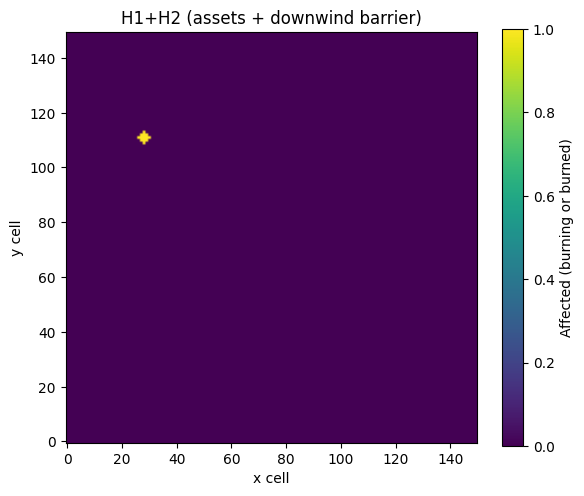

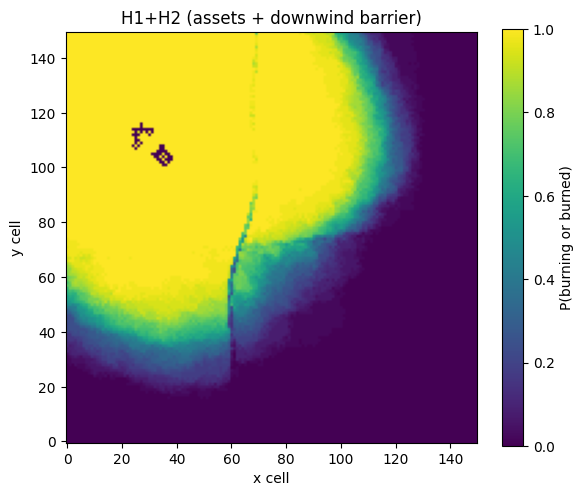

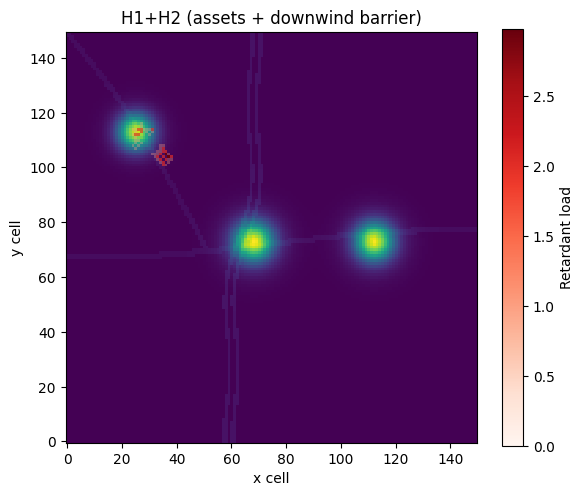

=== H2 downwind-only (long barrier) ===
[Heuristic] eval 001/10 | y=118.86 | best=118.86
           (x,y,phi) per drone:
           [[ 34.     102.       0.7496]
 [ 35.     102.       0.6644]
 [ 35.     102.       0.6994]
 [ 35.     102.       0.7532]
 [ 35.     102.       0.7533]
 [ 36.     102.       0.6984]
 [ 36.     102.       0.789 ]
 [ 36.     102.       0.8499]
 [ 36.     103.       0.8076]
 [ 37.     103.       0.6534]
 [ 37.     103.       0.7731]
 [ 37.     103.       0.8009]
 [ 37.     103.       0.8768]
 [ 37.     104.       0.7796]
 [ 37.     105.       0.7089]
 [ 37.     105.       0.7525]
 [ 38.     104.       0.6371]
 [ 38.     104.       0.6729]
 [ 38.     104.       0.7224]
 [ 38.     105.       0.7736]]
[Heuristic] eval 010/10 | y=119.811 | best=118.845
           (x,y,phi) per drone:
           [[ 34.     102.       0.7092]
 [ 34.     102.       0.8777]
 [ 35.     101.       0.6338]
 [ 35.     101.       0.8597]
 [ 35.     102.       0.5245]
 [ 35.     102.       0

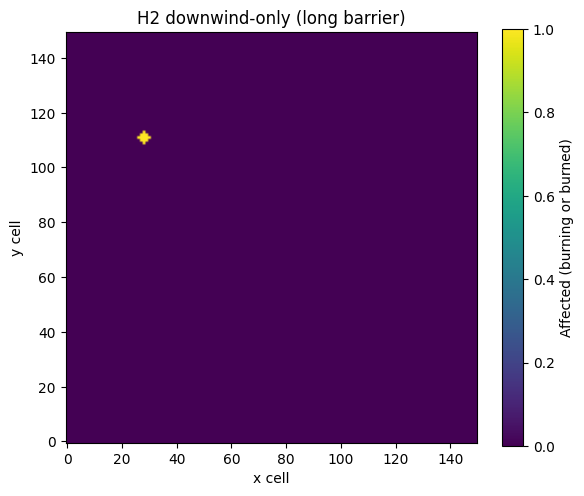

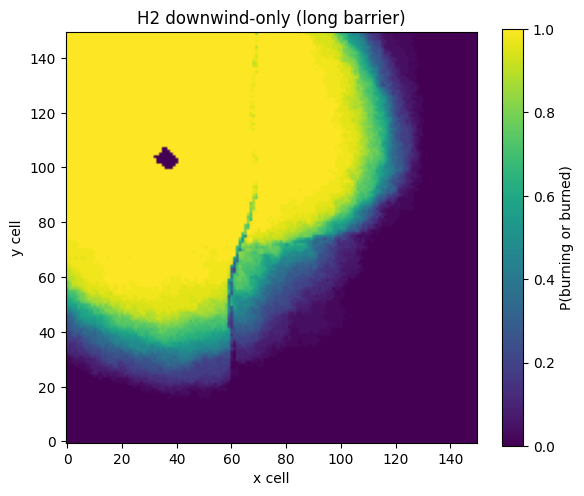

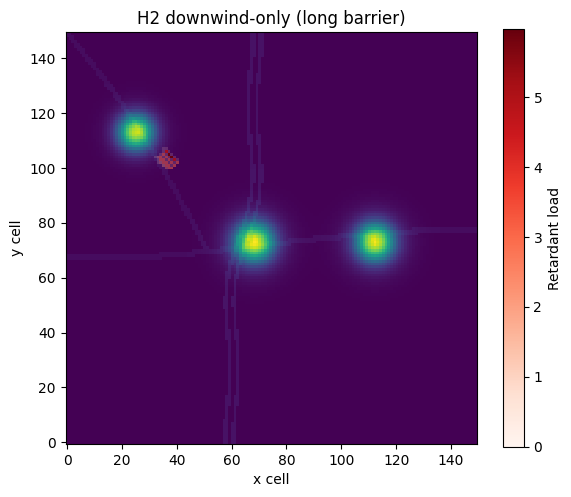

=== H3 shoulder/tangent-only (wind-scaled) ===
[Heuristic] eval 001/10 | y=119.199 | best=119.199
           (x,y,phi) per drone:
           [[  0.      86.       2.381 ]
 [  0.      93.       2.2865]
 [  0.     100.       2.2083]
 [  0.     108.       2.3163]
 [  9.      80.       2.2398]
 [ 18.      76.       2.3782]
 [ 21.      74.       2.3047]
 [ 22.      74.       2.3054]
 [ 28.      74.       2.4539]
 [ 33.     149.       3.975 ]
 [ 39.     149.       3.9896]
 [ 45.     149.       5.5387]
 [ 49.     149.       5.4814]
 [ 50.     149.       5.4901]
 [ 67.     122.       5.4158]
 [ 67.     131.       5.5965]
 [ 67.     133.       5.5771]
 [ 67.     137.       5.2364]
 [ 72.     114.       5.6174]
 [ 73.     112.       5.5169]]
[Heuristic] eval 010/10 | y=119.167 | best=119.167
           (x,y,phi) per drone:
           [[  0.      88.       2.3447]
 [  0.      95.       2.2958]
 [  0.     102.       2.3698]
 [  9.      80.       2.4147]
 [ 12.      79.       2.4278]
 [ 21.      74

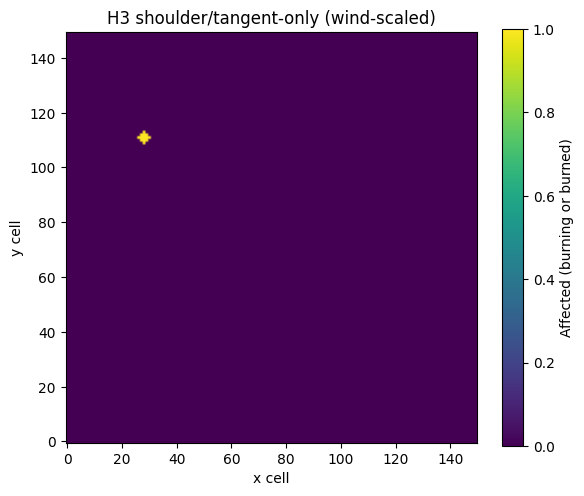

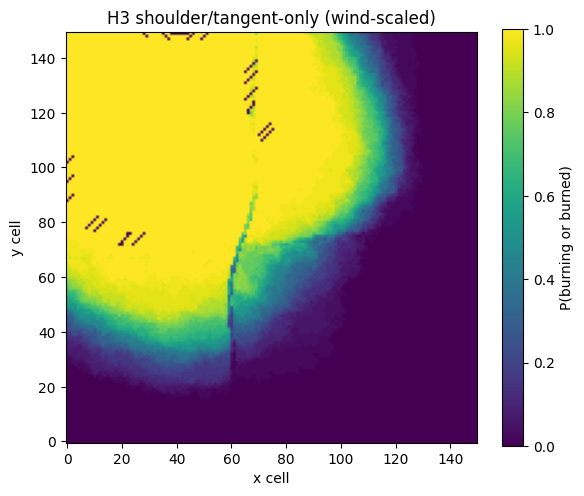

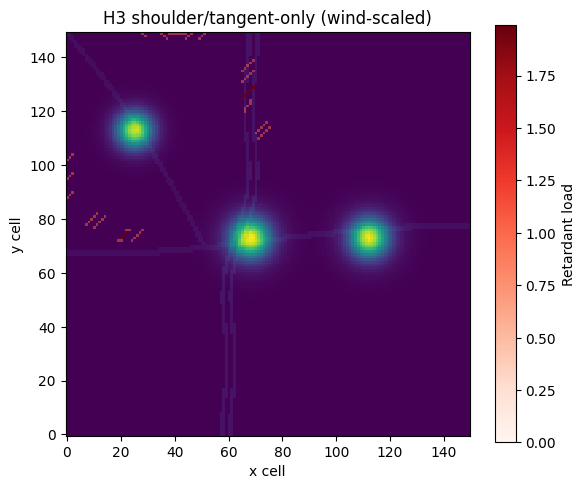

=== H1+H3 + boundary fallback ===
[Heuristic] eval 001/10 | y=117.008 | best=117.008
           (x,y,phi) per drone:
           [[  0.      95.       2.1874]
 [ 11.      81.       2.4251]
 [ 12.      80.       2.3864]
 [ 23.      98.       2.3769]
 [ 25.     111.       2.9311]
 [ 26.      92.       2.0586]
 [ 26.     110.       2.2104]
 [ 26.     112.       4.1405]
 [ 27.     113.       4.069 ]
 [ 28.     114.       5.0716]
 [ 29.     113.       5.4418]
 [ 34.      88.       2.0834]
 [ 36.     145.       3.9902]
 [ 45.     102.       0.767 ]
 [ 45.     118.       5.812 ]
 [ 46.     141.       5.5994]
 [ 47.     108.       0.6792]
 [ 52.     102.       0.8277]
 [ 58.     128.       5.5898]
 [ 62.     118.       5.4854]]
[Heuristic] eval 010/10 | y=117.211 | best=117.008
           (x,y,phi) per drone:
           [[  0.      91.       2.274 ]
 [  0.      92.       2.3518]
 [ 15.      79.       2.3959]
 [ 15.     113.       3.8652]
 [ 15.     122.       4.0096]
 [ 25.     111.       3.106

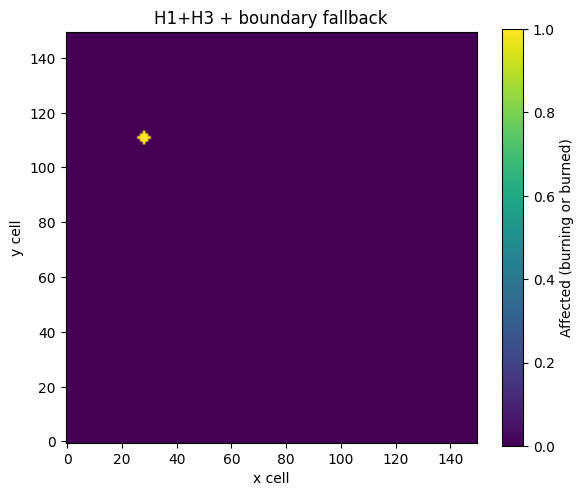

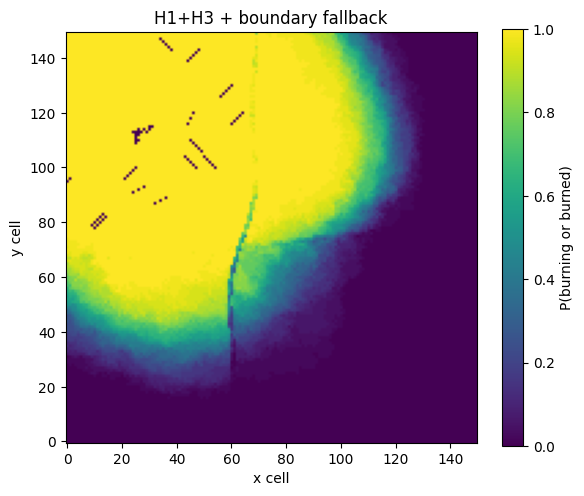

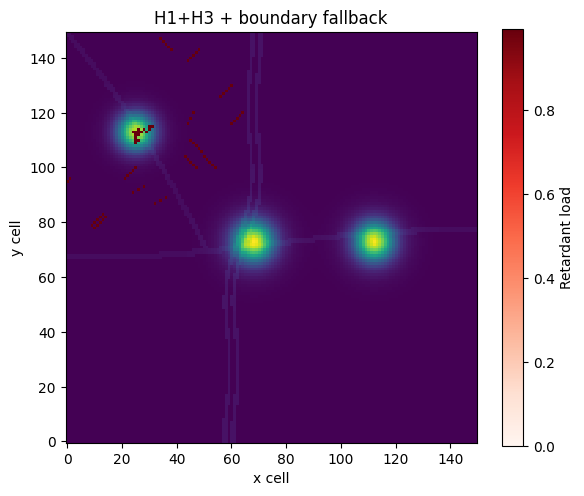

=== Full mix (H1/H2/H3 + boundary + control) ===
[Heuristic] eval 001/10 | y=117.162 | best=117.162
           (x,y,phi) per drone:
           [[ 11.      82.       2.1438]
 [ 25.     111.       2.9281]
 [ 26.     110.       2.3784]
 [ 26.     112.       3.8268]
 [ 27.     113.       3.9109]
 [ 29.      86.       2.0325]
 [ 33.     104.       0.7512]
 [ 34.     106.       0.4974]
 [ 34.     108.       0.6271]
 [ 34.     108.       0.7663]
 [ 36.     144.       3.7472]
 [ 36.     145.       3.6602]
 [ 42.      96.       0.9374]
 [ 48.     127.       5.6989]
 [ 49.     106.       0.7928]
 [ 49.     120.       5.7202]
 [ 50.     116.       5.9273]
 [ 52.     113.       5.7305]
 [ 54.     102.       0.9924]
 [ 58.     127.       5.7543]]
[Heuristic] eval 010/10 | y=116.955 | best=116.744
           (x,y,phi) per drone:
           [[  0.      97.       2.4805]
 [ 11.     112.       3.8557]
 [ 23.      78.       2.3001]
 [ 23.      78.       2.3669]
 [ 25.     111.       2.9763]
 [ 26.     1

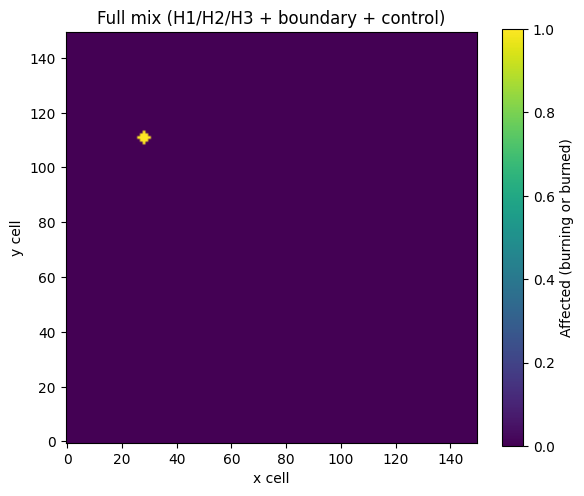

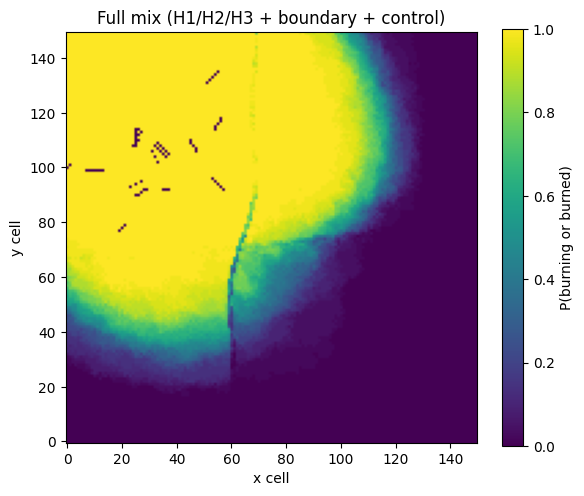

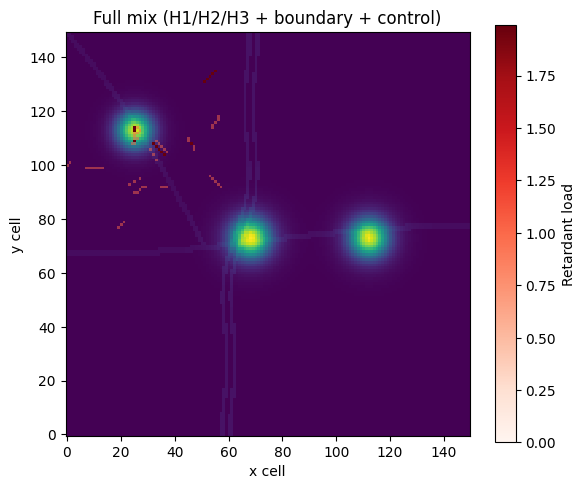

Summary (lower is better):
H1+H2 (assets + downwind barrier): best_y=115.198
H1 asset-heavy (tight assets): best_y=115.317
H1+H2+H3 (default): best_y=115.991
Full mix (H1/H2/H3 + boundary + control): best_y=116.744
H1+H3 + boundary fallback: best_y=117.008
H2 downwind-only (long barrier): best_y=118.845
H3 shoulder/tangent-only (wind-scaled): best_y=119.167


In [10]:
# Heuristic sweeps for H1/H2/H3
n_evals = 10
plot_each = True
n_sims_plot = 50

heuristic_experiments = [
    {
        "name": "H1+H2+H3 (default)",
        "heuristic_kwargs": {},
    },
    {
        "name": "H1 asset-heavy (tight assets)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking"],
            "asset_value_quantile": 0.95,
            "asset_alpha_range": (0.50, 0.85),
            "min_arc_sep_frac": 0.20,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H2 (assets + downwind barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "downwind_blocking"],
            "asset_value_quantile": 0.90,
            "downwind_offset_cells": 8.0,
            "downwind_head_align": 0.50,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
        },
    },
    {
        "name": "H2 downwind-only (long barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["downwind_blocking"],
            "downwind_offset_cells": 10.0,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "downwind_head_align": 0.45,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H3 shoulder/normal-only (wind-scaled)",
        "heuristic_kwargs": {
            "heuristic_modes": ["tangent_blocking"],
            "tangent_offset_cells": 3.0,
            "tangent_wind_scale": 3.0,
            "tangent_orientation": "normal",
            "tangent_shoulder_align": (0.20, 0.70),
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H3 + boundary fallback",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "tangent_blocking", "boundary"],
            "asset_value_quantile": 0.90,
            "tangent_offset_cells": 4.0,
            "value_bias": 0.5,
            "wind_bias": 1.5,
        },
    },
    {
        "name": "Full mix (H1/H2/H3 + boundary + control)",
        "heuristic_kwargs": {
            "heuristic_modes": [
                "fire_asset_blocking",
                "downwind_blocking",
                "tangent_blocking",
                "boundary",
                "control_tie_in",
            ],
            "control_bias": 2.0,
            "value_bias": 0.5,
            "asset_value_quantile": 0.90,
        },
    },
]

results = []
for exp in heuristic_experiments:
    print(f"=== {exp['name']} ===")
    best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=n_evals,
        heuristic_random_frac=0.0,
        heuristic_kwargs=exp["heuristic_kwargs"],
        print_every=n_evals,
    )
    results.append({
        "name": exp["name"],
        "best_y": best_y,
        "best_theta": best_theta,
        "best_params": best_params,
        "y_bests": y_bests,
    })
    if plot_each:
        drop_opt.plot_evolved_firestate(theta=best_theta, n_sims=n_sims_plot, title=exp["name"])

print("Summary (lower is better):")
for row in sorted(results, key=lambda r: r["best_y"]):
    print(f"{row['name']}: best_y={row['best_y']:.6g}")


=== H1+H2+H3 (default) ===
[Heuristic] Search grid set up with 6880 valid cells in grid.


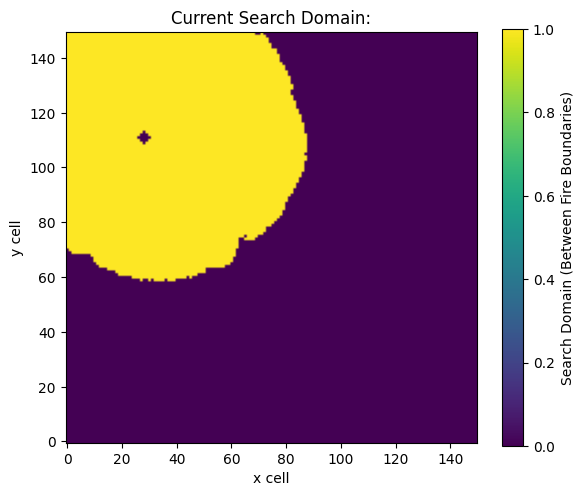

[Heuristic] eval 001/10 | y=190.499 | best=190.499
           (x,y,phi) per drone:
           [[ 15.      80.       2.6168]
 [ 26.     110.       2.4906]
 [ 26.     112.       3.9254]
 [ 27.     113.       3.9305]
 [ 32.     105.       0.6422]
 [ 32.     145.       4.0638]
 [ 32.     145.       4.1912]
 [ 34.     106.       0.7337]
 [ 34.     106.       0.8184]
 [ 57.     128.       5.278 ]]
[Heuristic] eval 010/10 | y=190.331 | best=190.041
           (x,y,phi) per drone:
           [[  1.      90.       2.2264]
 [ 26.     110.       2.5781]
 [ 26.     112.       3.7592]
 [ 27.     113.       3.9118]
 [ 32.     104.       0.8177]
 [ 32.     104.       0.9949]
 [ 35.     106.       0.6403]
 [ 45.     140.       5.5142]
 [ 61.     118.       5.3369]
 [ 61.     118.       5.6555]]
[Heuristic] done: best_y=190.041
[Heuristic] best params:
[[  8.      84.       2.1313]
 [ 26.     110.       2.7383]
 [ 26.     112.       4.0234]
 [ 27.     113.       3.9122]
 [ 33.     105.       0.8187]
 [

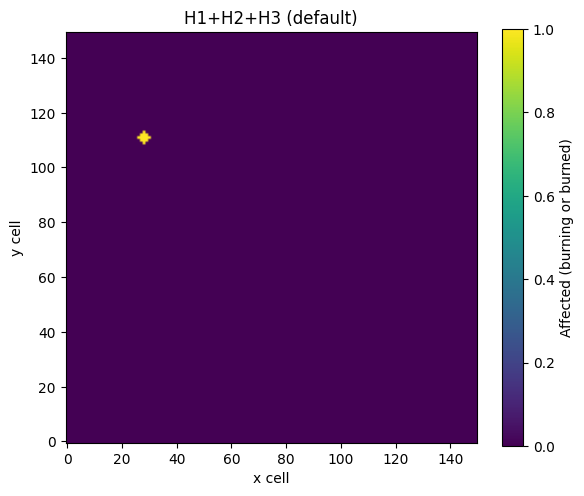

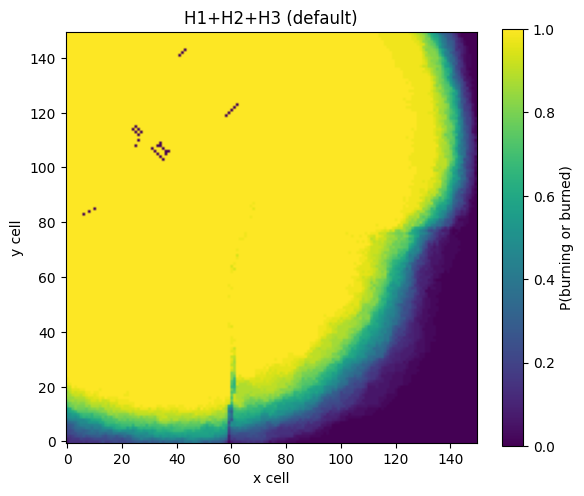

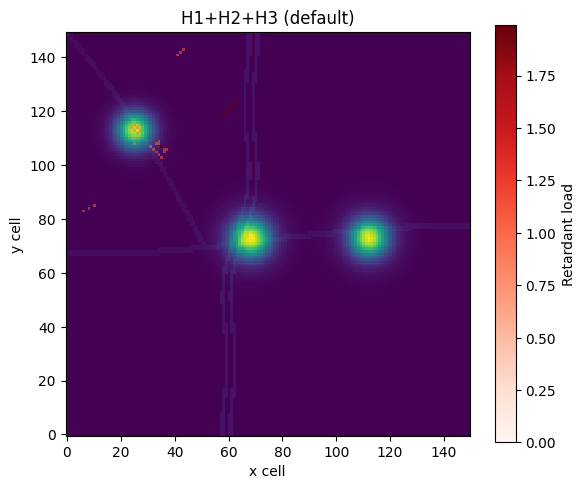

=== H1 asset-heavy (tight assets) ===
[Heuristic] eval 001/10 | y=189.405 | best=189.405
           (x,y,phi) per drone:
           [[ 25.     111.       3.1382]
 [ 26.     110.       2.2896]
 [ 26.     112.       2.7945]
 [ 26.     112.       3.9044]
 [ 26.     112.       5.0267]
 [ 27.     109.       2.5209]
 [ 27.     113.       2.802 ]
 [ 27.     113.       4.1897]
 [ 28.     114.       4.7868]
 [ 29.     113.       5.3774]]
[Heuristic] eval 010/10 | y=189.201 | best=189.052
           (x,y,phi) per drone:
           [[ 25.     111.       3.0164]
 [ 26.     110.       2.4601]
 [ 26.     112.       2.4955]
 [ 26.     112.       3.8971]
 [ 26.     112.       5.0387]
 [ 27.     109.       2.3889]
 [ 27.     113.       2.8971]
 [ 27.     113.       3.8795]
 [ 28.     114.       4.7615]
 [ 29.     113.       5.5236]]
[Heuristic] done: best_y=189.052
[Heuristic] best params:
[[ 25.     111.       3.1012]
 [ 26.     110.       2.4321]
 [ 26.     112.       2.851 ]
 [ 26.     112.       3.

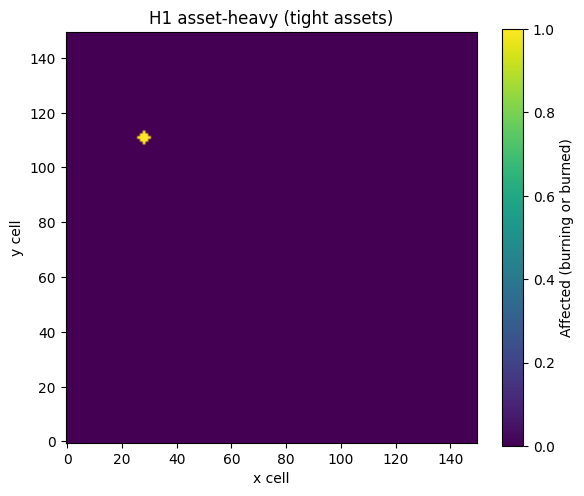

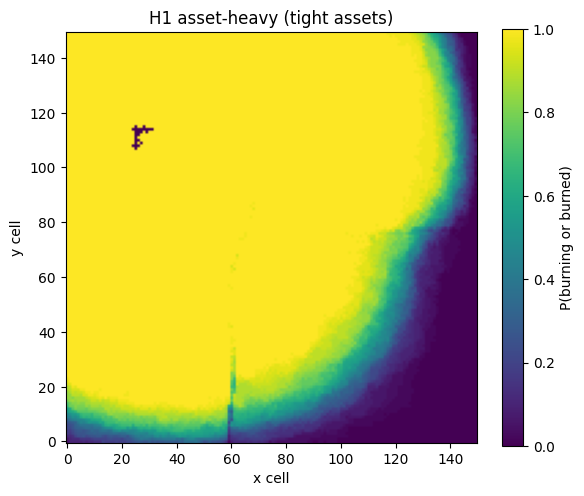

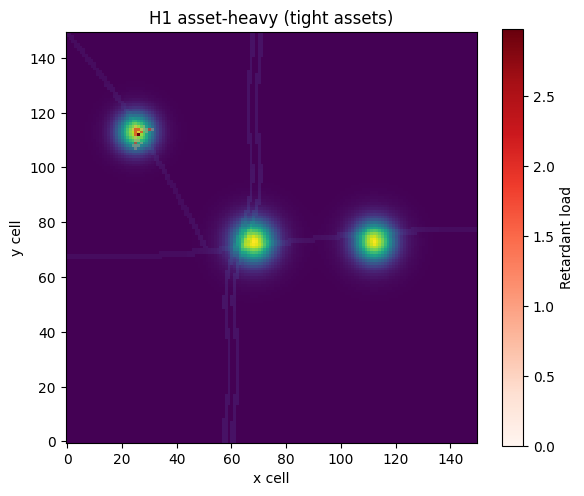

=== H1+H2 (assets + downwind barrier) ===
[Heuristic] eval 001/10 | y=189.301 | best=189.301
           (x,y,phi) per drone:
           [[ 25.     111.       2.812 ]
 [ 26.     110.       2.2781]
 [ 26.     112.       3.8874]
 [ 27.     113.       3.9917]
 [ 29.     113.       5.5739]
 [ 34.     103.       0.8355]
 [ 35.     104.       0.4614]
 [ 35.     104.       0.5228]
 [ 36.     105.       0.8194]
 [ 36.     106.       0.982 ]]
[Heuristic] eval 010/10 | y=189.677 | best=189.301
           (x,y,phi) per drone:
           [[ 25.     111.       3.1798]
 [ 26.     110.       2.3875]
 [ 26.     112.       4.2408]
 [ 27.     113.       3.8135]
 [ 29.     113.       5.6312]
 [ 33.     103.       0.6135]
 [ 34.     103.       0.5872]
 [ 34.     103.       1.1052]
 [ 36.     104.       0.9216]
 [ 37.     106.       0.6902]]
[Heuristic] done: best_y=189.301
[Heuristic] best params:
[[ 25.     111.       2.812 ]
 [ 26.     110.       2.2781]
 [ 26.     112.       3.8874]
 [ 27.     113.     

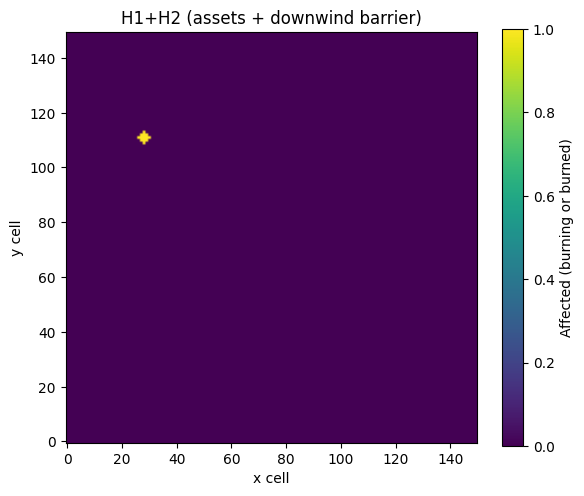

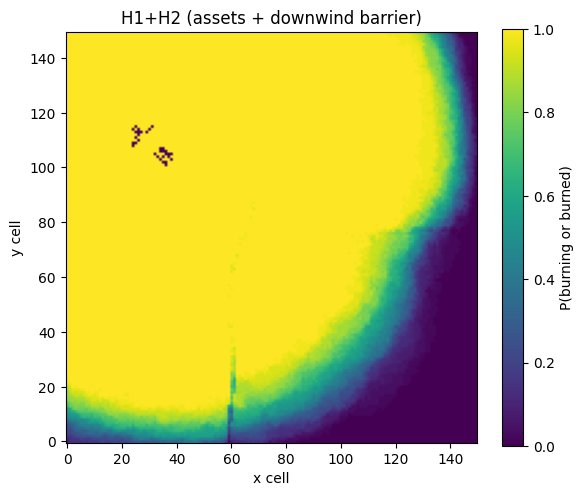

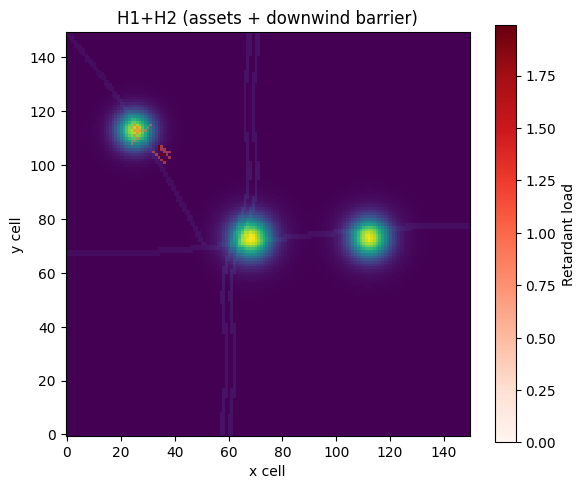

=== H2 downwind-only (long barrier) ===
[Heuristic] eval 001/10 | y=191.24 | best=191.24
           (x,y,phi) per drone:
           [[ 35.     102.       0.7234]
 [ 35.     102.       0.7876]
 [ 35.     102.       0.7926]
 [ 36.     102.       0.6473]
 [ 36.     102.       0.7717]
 [ 37.     103.       0.5902]
 [ 37.     103.       0.7284]
 [ 37.     105.       0.682 ]
 [ 38.     104.       0.7248]
 [ 38.     104.       0.84  ]]
[Heuristic] eval 010/10 | y=191.32 | best=190.762
           (x,y,phi) per drone:
           [[ 35.     101.       0.7595]
 [ 35.     102.       0.7079]
 [ 36.     102.       0.6471]
 [ 36.     102.       0.6864]
 [ 36.     102.       0.7472]
 [ 37.     103.       0.6806]
 [ 37.     103.       0.7935]
 [ 37.     105.       0.6234]
 [ 38.     104.       0.6664]
 [ 38.     104.       0.8128]]
[Heuristic] done: best_y=190.762
[Heuristic] best params:
[[ 34.     102.       0.7117]
 [ 35.     102.       0.7817]
 [ 35.     102.       0.9158]
 [ 36.     102.       0.7

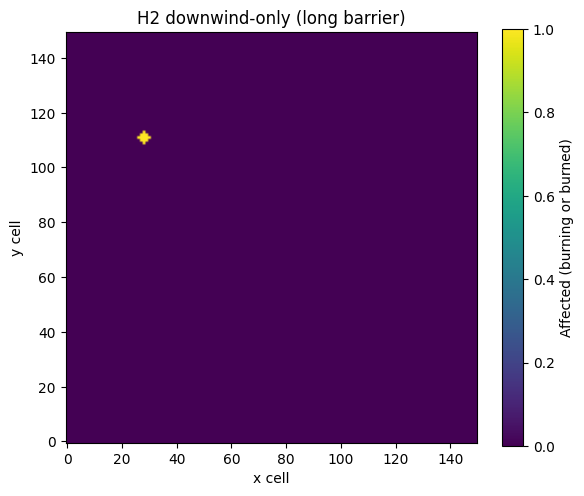

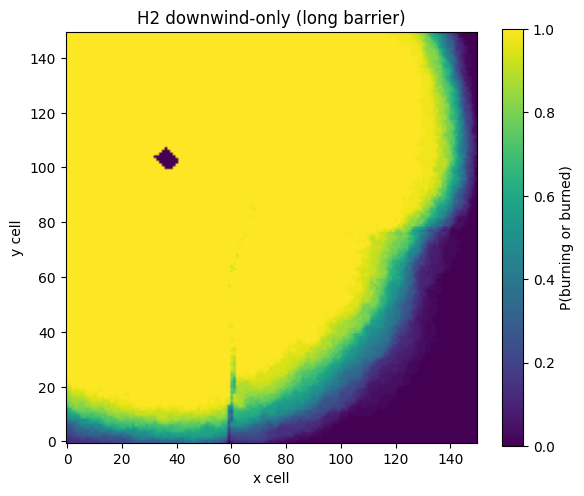

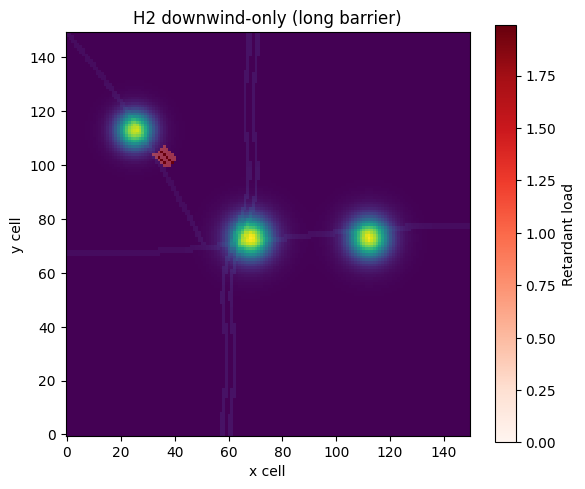

=== H3 shoulder/tangent-only (wind-scaled) ===
[Heuristic] eval 001/10 | y=191.69 | best=191.69
           (x,y,phi) per drone:
           [[  0.      93.       2.3258]
 [  6.      69.       2.2286]
 [  7.      69.       2.4285]
 [ 16.      64.       2.4041]
 [ 27.      63.       2.4363]
 [ 28.     149.       4.0307]
 [ 43.     149.       5.4745]
 [ 68.     138.       5.5391]
 [ 72.     130.       5.5277]
 [ 75.     121.       5.5362]]
[Heuristic] eval 010/10 | y=191.768 | best=191.602
           (x,y,phi) per drone:
           [[  0.      86.       2.4985]
 [  0.     102.       3.8332]
 [ 10.      66.       2.4697]
 [ 21.      63.       2.3259]
 [ 21.      63.       2.4763]
 [ 36.     149.       3.7642]
 [ 49.     149.       5.4282]
 [ 70.     134.       5.5457]
 [ 74.     125.       5.5398]
 [ 76.     116.       5.5279]]
[Heuristic] done: best_y=191.602
[Heuristic] best params:
[[  0.      89.       2.3684]
 [  0.     107.       3.9139]
 [  9.      68.       2.3851]
 [ 18.      64.  

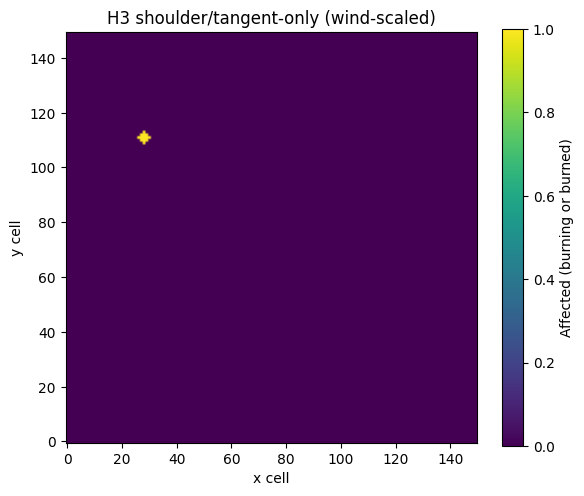

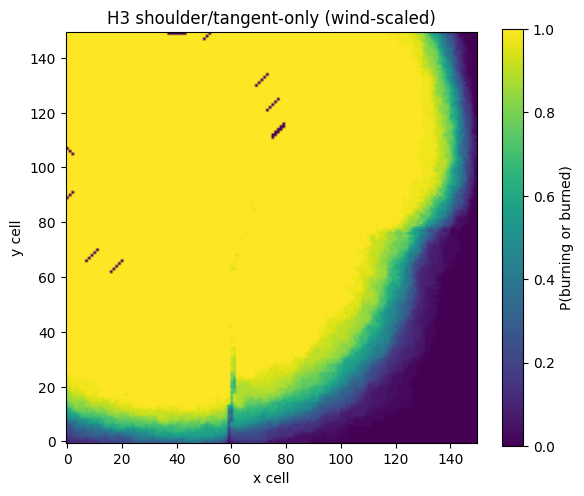

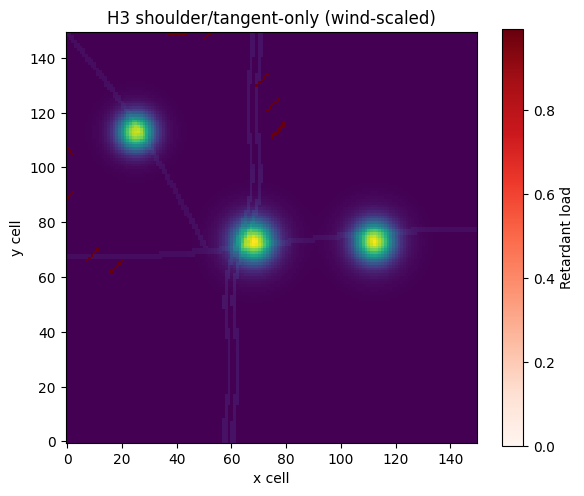

=== H1+H3 + boundary fallback ===
[Heuristic] eval 001/10 | y=190.563 | best=190.563
           (x,y,phi) per drone:
           [[  7.      84.       2.1884]
 [  7.      84.       2.3299]
 [  9.     104.       1.8441]
 [ 24.      84.       2.2647]
 [ 26.     110.       2.4268]
 [ 26.     112.       3.9607]
 [ 27.     113.       3.9327]
 [ 42.      83.       0.8798]
 [ 57.     112.       5.8159]
 [ 58.     129.       5.2852]]
[Heuristic] eval 010/10 | y=190.851 | best=190.256
           (x,y,phi) per drone:
           [[ 13.      86.       2.0869]
 [ 17.      78.       2.2558]
 [ 17.      78.       2.2737]
 [ 26.     110.       2.121 ]
 [ 26.     112.       4.0036]
 [ 27.     113.       4.1623]
 [ 38.      81.       0.5781]
 [ 43.     143.       5.547 ]
 [ 51.      88.       0.6713]
 [ 64.     122.       5.8666]]
[Heuristic] done: best_y=190.256
[Heuristic] best params:
[[ 13.      94.       1.9972]
 [ 20.      77.       2.2774]
 [ 26.      84.       2.1605]
 [ 26.     110.       2.2673

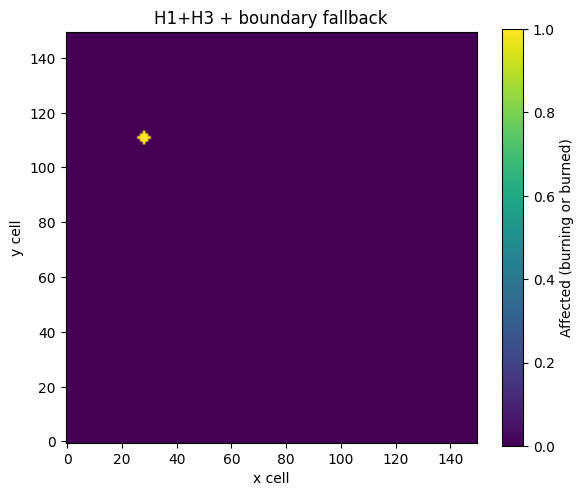

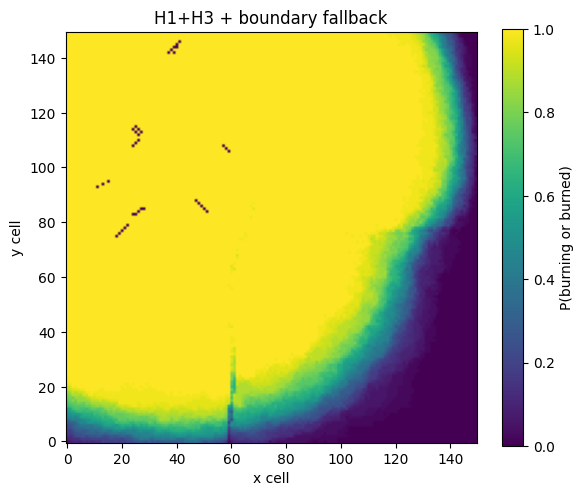

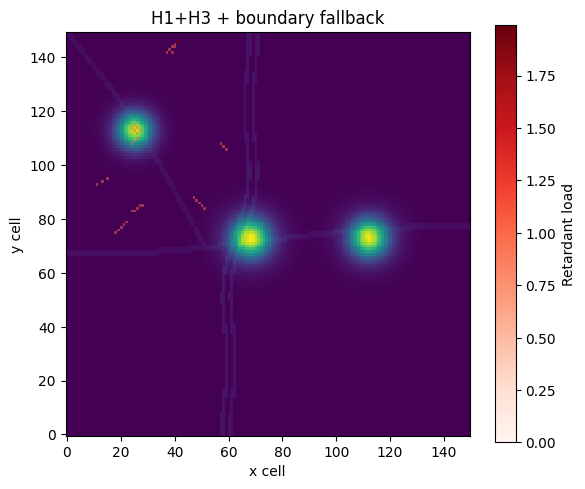

=== Full mix (H1/H2/H3 + boundary + control) ===
[Heuristic] eval 001/10 | y=190.581 | best=190.581
           (x,y,phi) per drone:
           [[  0.     104.       3.0892]
 [  0.     105.       4.0836]
 [ 17.      85.       1.5932]
 [ 26.     110.       2.1554]
 [ 26.     112.       4.0549]
 [ 29.      75.       2.1145]
 [ 35.     107.       0.6435]
 [ 35.     107.       0.9218]
 [ 48.     102.       0.8268]
 [ 55.     115.       5.5123]]
[Heuristic] eval 010/10 | y=190.386 | best=190.386
           (x,y,phi) per drone:
           [[  0.     101.       1.8925]
 [  0.     102.       2.3397]
 [ 16.     115.       3.865 ]
 [ 23.      92.       2.0791]
 [ 26.     110.       2.5527]
 [ 26.     112.       3.8738]
 [ 35.     107.       0.8841]
 [ 35.     107.       1.141 ]
 [ 43.     127.       6.1451]
 [ 50.     115.       5.7597]]
[Heuristic] done: best_y=190.386
[Heuristic] best params:
[[  0.     101.       1.8925]
 [  0.     102.       2.3397]
 [ 16.     115.       3.865 ]
 [ 23.      9

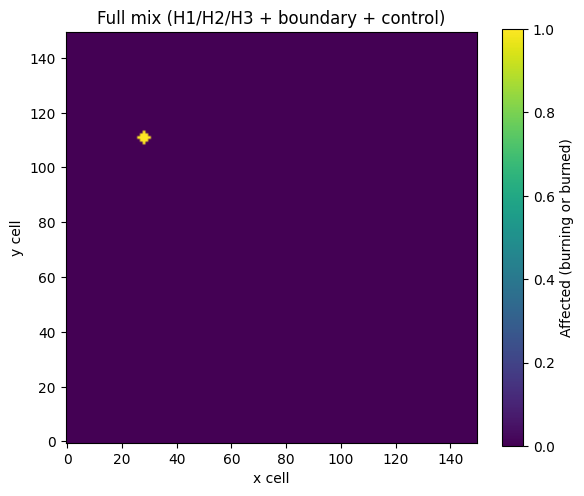

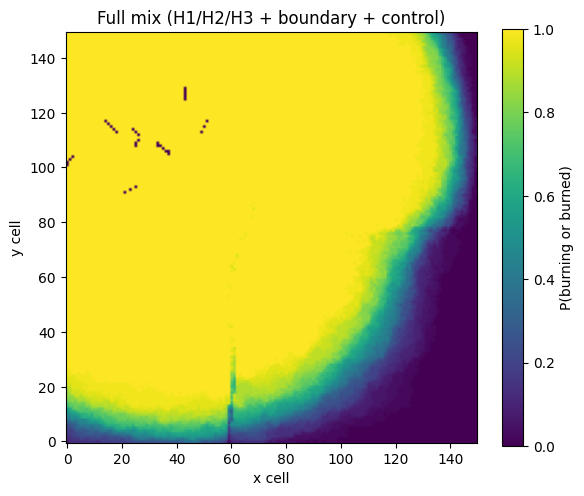

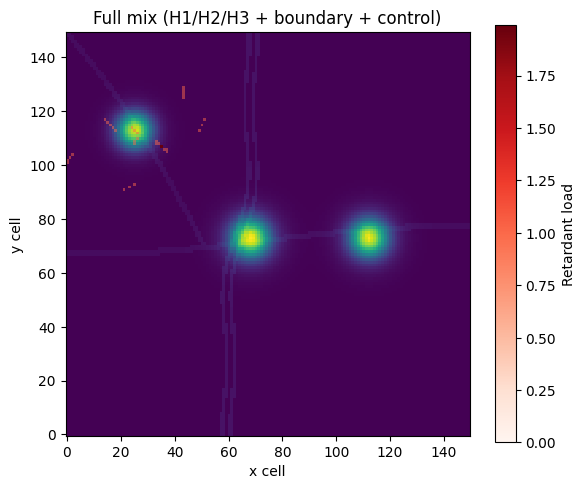

Summary (lower is better):
H1 asset-heavy (tight assets): best_y=189.052
H1+H2 (assets + downwind barrier): best_y=189.301
H1+H2+H3 (default): best_y=190.041
H1+H3 + boundary fallback: best_y=190.256
Full mix (H1/H2/H3 + boundary + control): best_y=190.386
H2 downwind-only (long barrier): best_y=190.762
H3 shoulder/tangent-only (wind-scaled): best_y=191.602


In [6]:
# Heuristic sweeps for H1/H2/H3
n_evals = 10
plot_each = True
n_sims_plot = 50

heuristic_experiments = [
    {
        "name": "H1+H2+H3 (default)",
        "heuristic_kwargs": {},
    },
    {
        "name": "H1 asset-heavy (tight assets)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking"],
            "asset_value_quantile": 0.95,
            "asset_alpha_range": (0.50, 0.85),
            "min_arc_sep_frac": 0.20,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H2 (assets + downwind barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "downwind_blocking"],
            "asset_value_quantile": 0.90,
            "downwind_offset_cells": 8.0,
            "downwind_head_align": 0.50,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
        },
    },
    {
        "name": "H2 downwind-only (long barrier)",
        "heuristic_kwargs": {
            "heuristic_modes": ["downwind_blocking"],
            "downwind_offset_cells": 10.0,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "downwind_head_align": 0.45,
            "downwind_orientation": "perp",
            "downwind_min_arc_sep_frac": 0.25,
            "downwind_layer_spacing_cells": 4.0,
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H3 shoulder/normal-only (wind-scaled)",
        "heuristic_kwargs": {
            "heuristic_modes": ["tangent_blocking"],
            "tangent_offset_cells": 3.0,
            "tangent_wind_scale": 3.0,
            "tangent_orientation": "normal",
            "tangent_shoulder_align": (0.20, 0.70),
            "phi_jitter_rad": np.deg2rad(5.0),
        },
    },
    {
        "name": "H1+H3 + boundary fallback",
        "heuristic_kwargs": {
            "heuristic_modes": ["fire_asset_blocking", "tangent_blocking", "boundary"],
            "asset_value_quantile": 0.90,
            "tangent_offset_cells": 4.0,
            "value_bias": 0.5,
            "wind_bias": 1.5,
        },
    },
    {
        "name": "Full mix (H1/H2/H3 + boundary + control)",
        "heuristic_kwargs": {
            "heuristic_modes": [
                "fire_asset_blocking",
                "downwind_blocking",
                "tangent_blocking",
                "boundary",
                "control_tie_in",
            ],
            "control_bias": 2.0,
            "value_bias": 0.5,
            "asset_value_quantile": 0.90,
        },
    },
]

results = []
for exp in heuristic_experiments:
    print(f"=== {exp['name']} ===")
    best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=n_evals,
        heuristic_random_frac=0.0,
        heuristic_kwargs=exp["heuristic_kwargs"],
        print_every=n_evals,
    )
    results.append({
        "name": exp["name"],
        "best_y": best_y,
        "best_theta": best_theta,
        "best_params": best_params,
        "y_bests": y_bests,
    })
    if plot_each:
        drop_opt.plot_evolved_firestate(theta=best_theta, n_sims=n_sims_plot, title=exp["name"])

print("Summary (lower is better):")
for row in sorted(results, key=lambda r: r["best_y"]):
    print(f"{row['name']}: best_y={row['best_y']:.6g}")


In [ ]:
drop_opt.run_heuristic_search(
    n_evals=10,
    K_grid=5000,
    verbose=True,
    heuristic_random_frac=0,
    print_every=5
)



[Heuristic] eval 001/10 | y=191.497 | best=191.497
           (x,y,phi) per drone:
           [[ 17.     116.       3.6756]
 [ 21.     121.       0.4565]
 [ 22.      44.       2.9945]
 [ 40.      61.       1.6094]
 [ 53.      16.       3.6441]
 [ 90.      88.       2.1472]
 [ 90.     102.       1.5013]
 [ 93.      60.       0.1124]
 [121.      49.       1.2008]
 [122.      45.       5.1635]]
[Heuristic] eval 005/10 | y=191.432 | best=191.081
           (x,y,phi) per drone:
           [[ 23.     138.       4.8754]
 [ 26.      56.       5.6356]
 [ 31.     122.       0.3254]
 [ 32.      36.       5.5669]
 [ 57.      43.       1.8999]
 [ 59.      27.       5.5665]
 [ 94.      15.       3.6246]
 [115.      75.       4.829 ]
 [132.     103.       0.2761]
 [135.      81.       5.7071]]
[Heuristic] eval 010/10 | y=191.351 | best=191.081
           (x,y,phi) per drone:
           [[  3.      36.       2.1595]
 [ 21.     111.       5.0758]
 [ 41.     149.       1.8643]
 [ 42.     103.       2.87

(array([0.4362, 0.3893, 0.0121, 0.906 , 0.8255, 0.1941, 0.7248, 0.443 ,
        0.9751, 0.0537, 0.4161, 0.5754, 0.7517, 0.4027, 0.1317, 0.6644,
        0.5302, 0.0047, 0.1946, 0.5302, 0.409 , 0.1946, 0.6644, 0.4344,
        0.7584, 0.6443, 0.5328, 0.7651, 0.604 , 0.6808]),
 array([[  8.    ,  62.    ,   3.6153],
        [ 29.    ,  79.    ,   2.57  ],
        [ 29.    ,  99.    ,   2.7296],
        [ 65.    ,  58.    ,   0.0763],
        [ 99.    ,  79.    ,   0.0297],
        [108.    ,  66.    ,   6.127 ],
        [112.    ,  60.    ,   0.8276],
        [113.    ,  96.    ,   3.3477],
        [114.    ,  90.    ,   4.2776],
        [135.    , 123.    ,   1.2199]]),
 191.0810789838164,
 (array([[ 0.1141,  0.7785, -0.5089, -0.8608,  0.1409,  0.8121,  0.4408,
           0.8976,  0.1477,  0.2953,  0.1466, -0.9892,  0.2685,  0.4094,
           0.9993, -0.0386,  0.3557,  0.1074, -0.4816, -0.8764,  0.604 ,
           0.5906,  0.8384, -0.545 ,  0.604 ,  0.6846,  0.9976,  0.0694,
           0

[BO] Search grid set up with 33750 valid cells in grid.


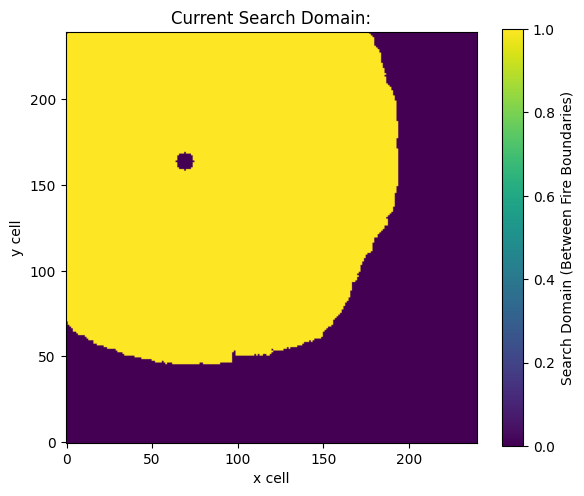

[BO] init: n_init=50, dim=15, n_cells=33750
[BO] init: best_y=118.974, mean_y=119.165, std_y=0.046679


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/150 | y_next=119.104 | best_y=118.974 (no-improve) | EI_max=8.41e-08 | mu=119.165 | std=0.0467
      proposed (x,y,phi) per drone:
      [[ 21.     162.       3.7612]
 [100.     113.       6.2325]
 [153.     136.       3.2466]
 [187.     127.       5.5541]
 [189.     154.       5.8298]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=0.001, ly=48.7, lphi=1.72, nu=2.5) + WhiteKernel(noise_level=2.48e-05)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/D

[BO] iter 010/150 | y_next=118.957 | best_y=118.957 (improved) | EI_max=0.000318 | mu=119.054 | std=0.0436
      proposed (x,y,phi) per drone:
      [[ 24.      99.       4.4306]
 [ 39.     115.       4.5283]
 [ 73.     128.       0.9489]
 [113.     110.       1.002 ]
 [115.     150.       4.9964]]
      gp.kernel_ = 0.903**2 * TiedXYFiMatern(lx=0.0553, ly=0.0184, lphi=0.763, nu=2.5) + WhiteKernel(noise_level=0.0672)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda

[BO] iter 020/150 | y_next=119.147 | best_y=118.93 (no-improve) | EI_max=0.000454 | mu=119.046 | std=0.0613
      proposed (x,y,phi) per drone:
      [[ 27.     101.       4.6241]
 [ 40.     116.       4.7503]
 [ 77.     131.       0.8772]
 [113.     108.       0.9152]
 [115.     154.       4.8962]]
      gp.kernel_ = 0.672**2 * TiedXYFiMatern(lx=126, ly=0.0238, lphi=0.449, nu=2.5) + WhiteKernel(noise_level=0.348)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The op

[BO] iter 030/150 | y_next=119.076 | best_y=118.82 (no-improve) | EI_max=0.000268 | mu=118.943 | std=0.0597
      proposed (x,y,phi) per drone:
      [[ 32.     104.       4.7195]
 [ 32.     119.       4.426 ]
 [ 83.     130.       0.9441]
 [ 99.     110.       0.7438]
 [126.     153.       4.6579]]
      gp.kernel_ = 0.85**2 * TiedXYFiMatern(lx=10.6, ly=0.0162, lphi=0.278, nu=2.5) + WhiteKernel(noise_level=0.0489)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgre

KeyboardInterrupt: 

In [ ]:
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=100,
    n_iters=300,
    n_candidates=2 ** 12,
    xi=0.01,
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3,
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=5,
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20.0),
)

## Results summary

In [ ]:
print("best_value:", best_value)
print("best_params (x, y, phi per drone):")
print(best_params)

plt.figure(figsize=(7, 4))
plt.plot(y_bests, lw=2)
plt.xlabel("Iteration")
plt.ylabel("Best objective so far")
plt.title("BO convergence")
plt.tight_layout()